In [288]:
# Import library
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
import matplotlib.ticker as ticker
from sklearn import metrics
import time
import math
import scipy.stats as stats
import itertools

In [192]:
# Load SAFE stock dataset
df_safe = pd.read_excel(
    'transportation_stocks.xlsx', sheet_name='SAFE.JK')
df_safe.set_index('Date', drop=True, inplace=True)
df_safe.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2011-04-01,115000000.0,115000000.0,115000000.0,115000000.0,115000000.0,3500.0
2011-04-04,115000000.0,115000000.0,115000000.0,115000000.0,115000000.0,3500.0
2011-04-05,115000000.0,115000000.0,115000000.0,115000000.0,115000000.0,3500.0
2011-04-06,115000000.0,115000000.0,115000000.0,115000000.0,115000000.0,3500.0
2011-04-07,115000000.0,115000000.0,115000000.0,115000000.0,115000000.0,3500.0


In [193]:
# Check datatypes
print(df_safe.dtypes)

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object


In [194]:
# Check missing value
print(df_safe.isnull().sum())

Open         8
High         8
Low          8
Close        8
Adj Close    8
Volume       8
dtype: int64


In [195]:
# Fill missing value using mean imputation
for i in df_safe[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]:
    df_safe[i].fillna(df_safe[i].mean(), inplace=True)

print(df_safe.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


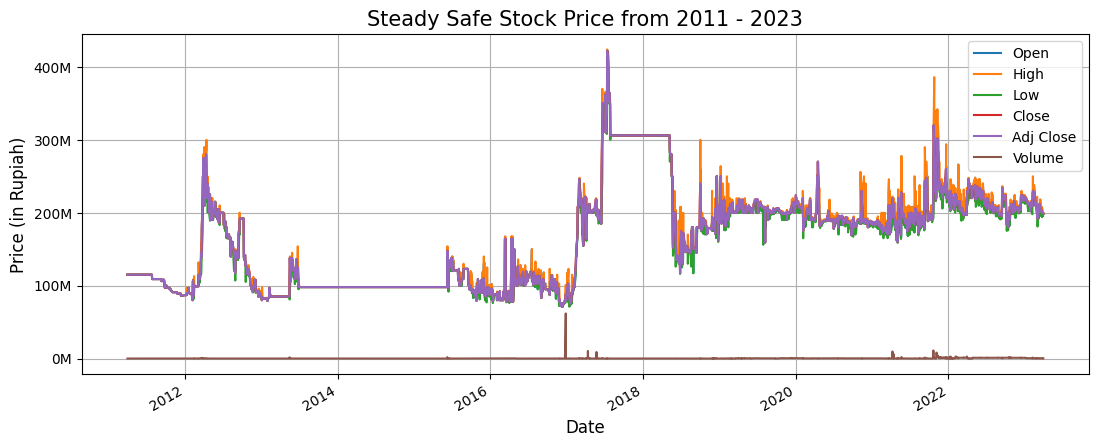

In [196]:
# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x/1e6)
# Visualize the historical prices from 2022 - 2023
df_safe.plot(figsize=(13,5))
plt.title('Steady Safe Stock Price from 2011 - 2023', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (in Rupiah)', fontsize=12)
plt.legend()
plt.grid(True)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

In [197]:
# Select the close price column as the target variable
target_col = 'Close'

# Create a new dataframe with only the target variable
target_df = pd.DataFrame(df_safe[target_col])

# Split the data into training and testing sets
train_size = int(len(target_df) * 0.9)
train_df = target_df[:train_size]
test_df = target_df[train_size:]
print('Training Set: ', train_df.shape)
print('Testing Set: ', test_df.shape)

Training Set:  (2682, 1)
Testing Set:  (298, 1)


In [198]:
# Scale the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)
print('Training Scaled: ', train_scaled[0:5], '\n')
print('Testing Scaled: ', test_scaled[0:5])

Training Scaled:  [[0.12535613]
 [0.12535613]
 [0.12535613]
 [0.12535613]
 [0.12535613]] 

Testing Scaled:  [[0.41880342]
 [0.43589744]
 [0.4017094 ]
 [0.42450142]
 [0.42450142]]


In [199]:
# Define the sequence length and number of features
sequence_length = 60
num_features = 1

# Define the function to create sequences
def create_sequences(X, y, seq_length):
    X_sequences, y_sequences = [], []
    for i in range(seq_length, len(X)):
        X_sequences.append(X[i-seq_length:i, :])
        y_sequences.append(y[i, :])
    return np.array(X_sequences), np.array(y_sequences)

# Create training sequences and labels
X_train, y_train = create_sequences(train_scaled, train_scaled, sequence_length)

# Create testing sequences and labels
X_test, y_test = create_sequences(test_scaled, test_scaled, sequence_length)

# Print the shape of the training and testing sets
print('X train shape:', X_train.shape)
print('y train shape:', y_train.shape)
print('X test shape:', X_test.shape)
print('y test shape:', y_test.shape)

X train shape: (2622, 60, 1)
y train shape: (2622, 1)
X test shape: (238, 60, 1)
y test shape: (238, 1)


## LSTM Default Model

In [200]:
# define the model
model = Sequential()
model.add(LSTM(32, input_shape=(sequence_length, num_features)))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error')
# train the model
start_time=time.time()
model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1, validation_split=0.1)
end_time=time.time()
model.summary()
model.save('models/safe_lstm_default.h5')

Epoch 1/10
24/24 [==============================] - 5s 69ms/step - loss: 0.0149 - val_loss: 0.0032
Epoch 2/10
24/24 [==============================] - 1s 35ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 3/10
24/24 [==============================] - 1s 35ms/step - loss: 0.0022 - val_loss: 0.0028
Epoch 4/10
24/24 [==============================] - 1s 36ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 5/10
24/24 [==============================] - 1s 37ms/step - loss: 0.0017 - val_loss: 0.0035
Epoch 6/10
24/24 [==============================] - 1s 41ms/step - loss: 0.0016 - val_loss: 0.0026
Epoch 7/10
24/24 [==============================] - 1s 37ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 8/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 9/10
24/24 [==============================] - 1s 44ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 10/10
24/24 [==============================] - 1s 51ms/step - loss: 0.0013 - val_loss: 0.0024
Model: "s

In [201]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 13ms/step
Mean Absolute Error (MAE): 0.0233534
Mean Absolute Percentage Error (MAPE): 0.05954
Root Mean Squared Error (RMSE): 0.02823
Mean Squared Error (MSE): 0.0007969
R-Squared (R2): 0.209648
T-Statistic 0.9711
P-Value 9.115719149122015e-05
Elapsed Time (min): 13.96


7/7 [==============================] - 0s 11ms/step


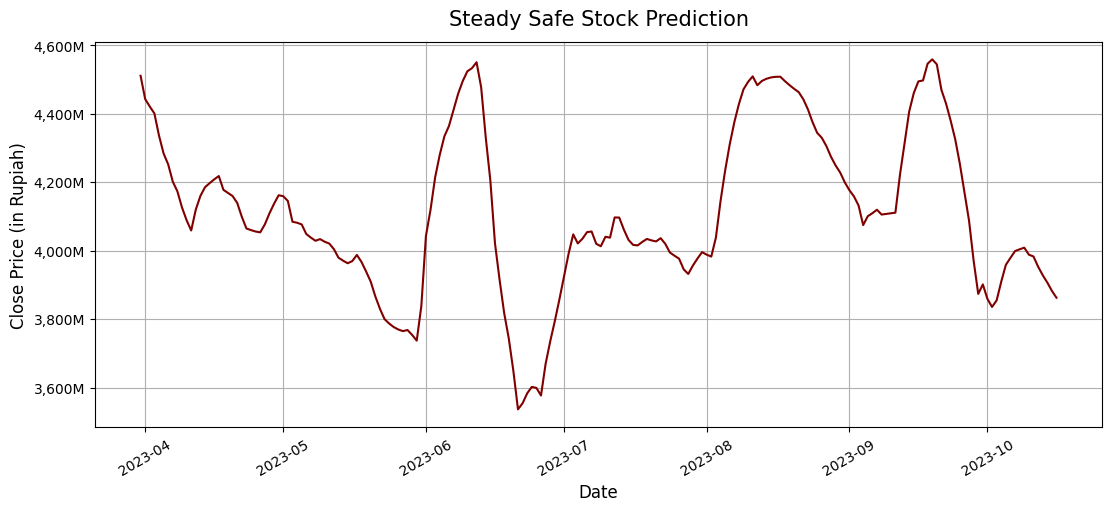

In [202]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Adam

In [203]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_linear_adam.h5')

Epoch 1/10
24/24 [==============================] - 26s 529ms/step - loss: 0.0137 - val_loss: 0.0040
Epoch 2/10
24/24 [==============================] - 10s 404ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 3/10
24/24 [==============================] - 10s 409ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 4/10
24/24 [==============================] - 9s 392ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 5/10
24/24 [==============================] - 10s 419ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 6/10
24/24 [==============================] - 10s 396ms/step - loss: 0.0022 - val_loss: 0.0026
Epoch 7/10
24/24 [==============================] - 9s 392ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 8/10
24/24 [==============================] - 9s 368ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 9/10
24/24 [==============================] - 9s 381ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 10/10
24/24 [==============================] - 10s 440ms/step - loss: 0.0021 - val_loss: 

In [204]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 47ms/step
Mean Absolute Error (MAE): 0.0207019
Mean Absolute Percentage Error (MAPE): 0.05281
Root Mean Squared Error (RMSE): 0.0257
Mean Squared Error (MSE): 0.0006603
R-Squared (R2): 0.345178
T-Statistic 0.9757
P-Value 0.0004197087837383151
Elapsed Time (min): 13.96


7/7 [==============================] - 0s 53ms/step


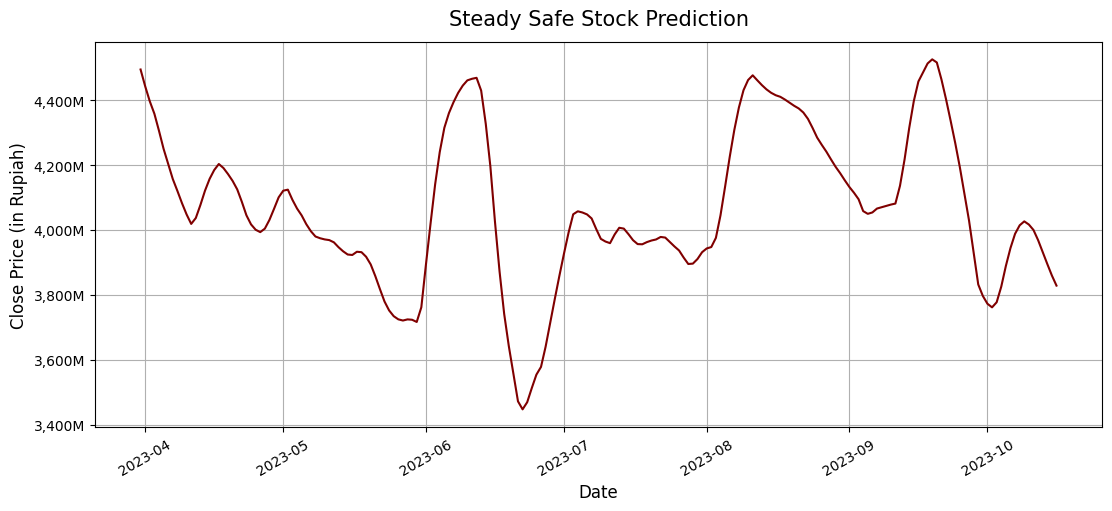

In [205]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaGrad

In [206]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_linear_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 28s 551ms/step - loss: 0.0807 - val_loss: 0.0619
Epoch 2/10
24/24 [==============================] - 11s 470ms/step - loss: 0.0472 - val_loss: 0.0336
Epoch 3/10
24/24 [==============================] - 11s 477ms/step - loss: 0.0399 - val_loss: 0.0234
Epoch 4/10
24/24 [==============================] - 13s 526ms/step - loss: 0.0355 - val_loss: 0.0193
Epoch 5/10
24/24 [==============================] - 13s 525ms/step - loss: 0.0332 - val_loss: 0.0170
Epoch 6/10
24/24 [==============================] - 12s 507ms/step - loss: 0.0311 - val_loss: 0.0156
Epoch 7/10
24/24 [==============================] - 11s 468ms/step - loss: 0.0282 - val_loss: 0.0144
Epoch 8/10
24/24 [==============================] - 11s 477ms/step - loss: 0.0261 - val_loss: 0.0135
Epoch 9/10
24/24 [==============================] - 12s 493ms/step - loss: 0.0244 - val_loss: 0.0123
Epoch 10/10
24/24 [==============================] - 12s 492ms/step - loss: 0.0223 - val_lo

In [207]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 5s 69ms/step
Mean Absolute Error (MAE): 0.1013683
Mean Absolute Percentage Error (MAPE): 0.2485
Root Mean Squared Error (RMSE): 0.10537
Mean Squared Error (MSE): 0.0111023
R-Squared (R2): -10.010493
T-Statistic 0.947
P-Value 1.2940834892560815e-07
Elapsed Time (min): 13.96


7/7 [==============================] - 0s 62ms/step


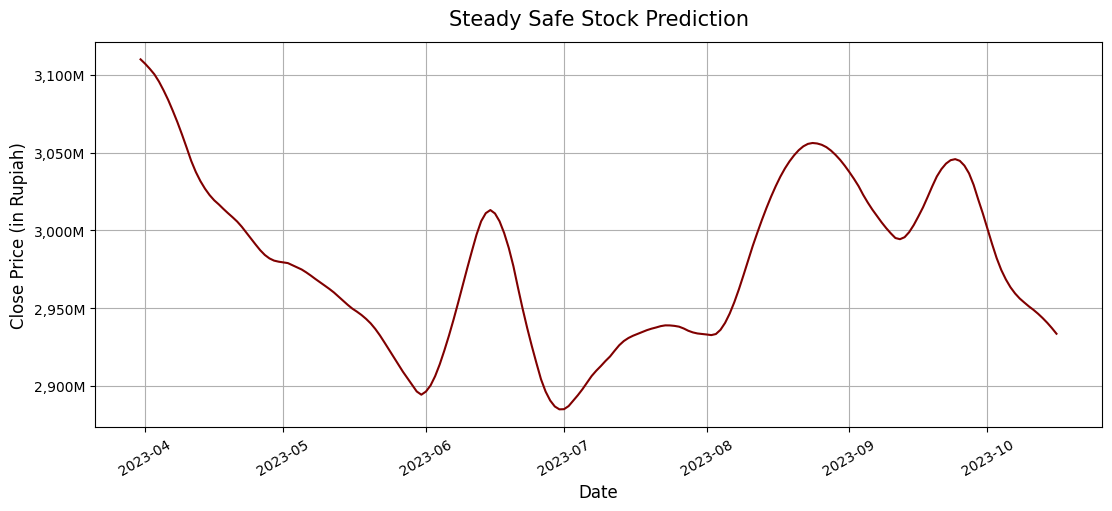

In [208]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - Nadam

In [209]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_linear_nadam.h5')

Epoch 1/10
24/24 [==============================] - 33s 672ms/step - loss: 0.0148 - val_loss: 0.0038
Epoch 2/10
24/24 [==============================] - 13s 536ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 3/10
24/24 [==============================] - 13s 527ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 4/10
24/24 [==============================] - 13s 537ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 5/10
24/24 [==============================] - 12s 493ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 6/10
24/24 [==============================] - 12s 496ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 7/10
24/24 [==============================] - 14s 581ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 8/10
24/24 [==============================] - 14s 579ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 9/10
24/24 [==============================] - 13s 555ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 10/10
24/24 [==============================] - 14s 590ms/step - loss: 0.0018 - val_lo

In [210]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 6s 73ms/step
Mean Absolute Error (MAE): 0.0226847
Mean Absolute Percentage Error (MAPE): 0.05775
Root Mean Squared Error (RMSE): 0.02748
Mean Squared Error (MSE): 0.000755
R-Squared (R2): 0.251201
T-Statistic 0.9763
P-Value 0.0005096399108879268
Elapsed Time (min): 13.96


7/7 [==============================] - 0s 63ms/step


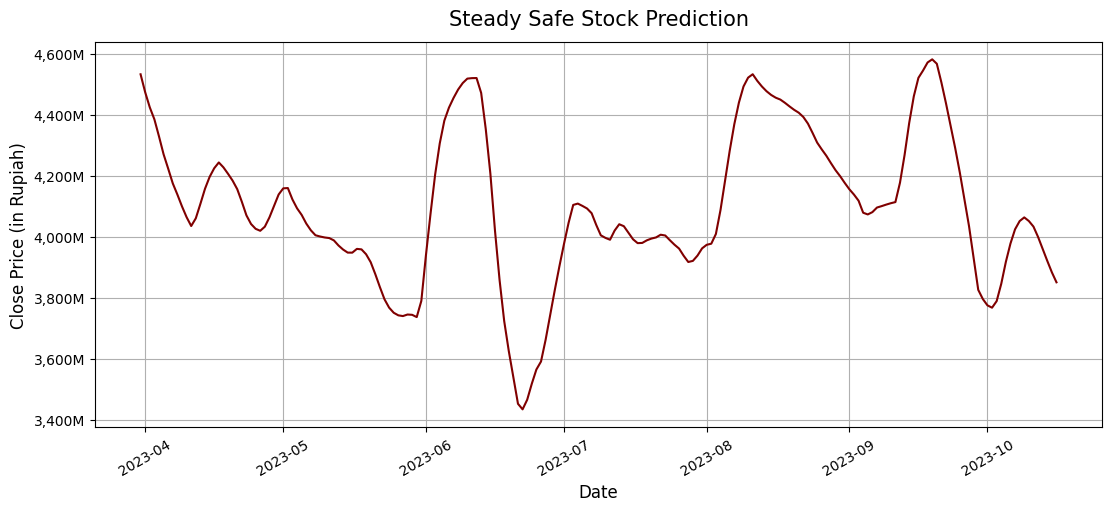

In [211]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - RMSProp

In [212]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_linear_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 29s 633ms/step - loss: 0.0134 - val_loss: 0.0094
Epoch 2/10
24/24 [==============================] - 12s 503ms/step - loss: 0.0049 - val_loss: 0.0034
Epoch 3/10
24/24 [==============================] - 12s 497ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 4/10
24/24 [==============================] - 11s 462ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 5/10
24/24 [==============================] - 11s 478ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 6/10
24/24 [==============================] - 12s 487ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 7/10
24/24 [==============================] - 13s 534ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 8/10
24/24 [==============================] - 13s 555ms/step - loss: 0.0023 - val_loss: 0.0052
Epoch 9/10
24/24 [==============================] - 13s 551ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 10/10
24/24 [==============================] - 13s 552ms/step - loss: 0.0022 - val_lo

In [213]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 5s 69ms/step
Mean Absolute Error (MAE): 0.0224491
Mean Absolute Percentage Error (MAPE): 0.05527
Root Mean Squared Error (RMSE): 0.02819
Mean Squared Error (MSE): 0.0007949
R-Squared (R2): 0.211629
T-Statistic 0.9727
P-Value 0.0001526668347651139
Elapsed Time (min): 13.96


7/7 [==============================] - 0s 62ms/step


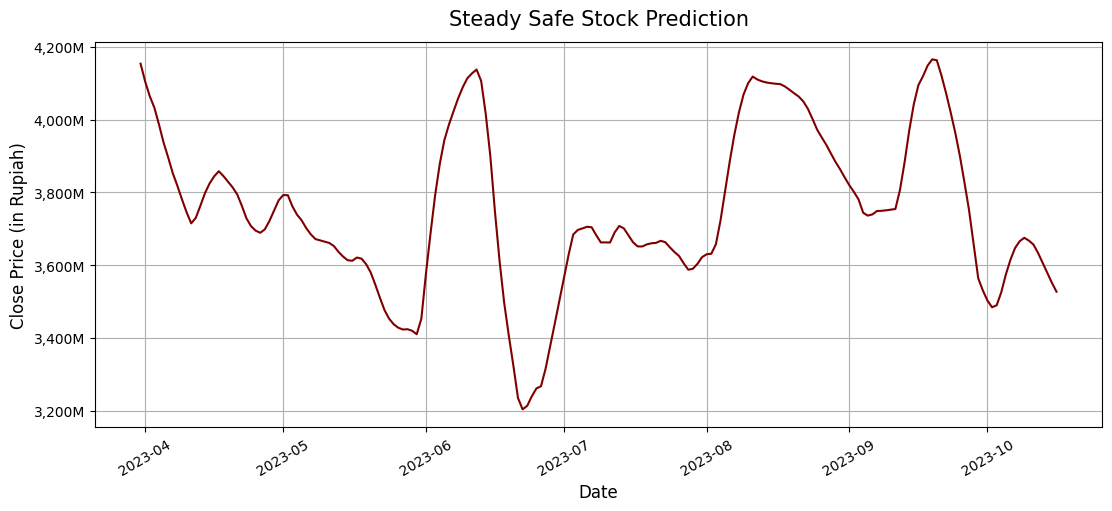

In [214]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaDelta

In [215]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_linear_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 33s 590ms/step - loss: 0.0779 - val_loss: 0.1140
Epoch 2/10
24/24 [==============================] - 12s 486ms/step - loss: 0.0771 - val_loss: 0.1119
Epoch 3/10
24/24 [==============================] - 14s 589ms/step - loss: 0.0758 - val_loss: 0.1098
Epoch 4/10
24/24 [==============================] - 14s 590ms/step - loss: 0.0747 - val_loss: 0.1077
Epoch 5/10
24/24 [==============================] - 15s 620ms/step - loss: 0.0723 - val_loss: 0.1056
Epoch 6/10
24/24 [==============================] - 13s 548ms/step - loss: 0.0709 - val_loss: 0.1034
Epoch 7/10
24/24 [==============================] - 13s 555ms/step - loss: 0.0703 - val_loss: 0.1012
Epoch 8/10
24/24 [==============================] - 14s 589ms/step - loss: 0.0681 - val_loss: 0.0991
Epoch 9/10
24/24 [==============================] - 13s 543ms/step - loss: 0.0669 - val_loss: 0.0969
Epoch 10/10
24/24 [==============================] - 13s 555ms/step - loss: 0.0654 - val_lo

In [216]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 66ms/step
Mean Absolute Error (MAE): 0.3222696
Mean Absolute Percentage Error (MAPE): 0.80197
Root Mean Squared Error (RMSE): 0.32361
Mean Squared Error (MSE): 0.1047215
R-Squared (R2): -102.855582
T-Statistic 0.953
P-Value 5.453237008623546e-07
Elapsed Time (min): 13.96


7/7 [==============================] - 1s 69ms/step


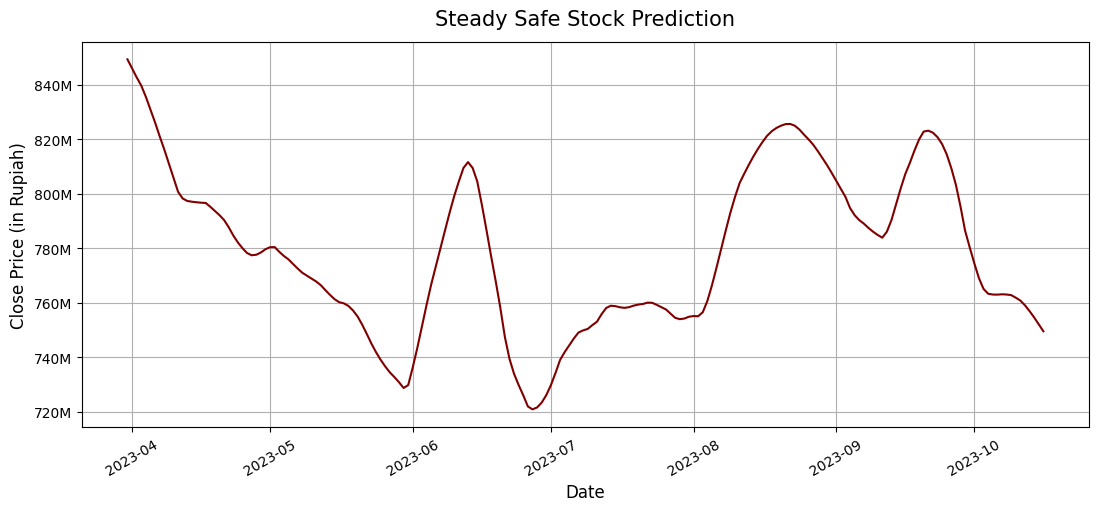

In [217]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - SGD

In [218]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_linear_sgd.h5')

Epoch 1/10
24/24 [==============================] - 27s 773ms/step - loss: 0.0498 - val_loss: 0.0194
Epoch 2/10
24/24 [==============================] - 13s 559ms/step - loss: 0.0316 - val_loss: 0.0158
Epoch 3/10
24/24 [==============================] - 15s 622ms/step - loss: 0.0248 - val_loss: 0.0124
Epoch 4/10
24/24 [==============================] - 16s 658ms/step - loss: 0.0198 - val_loss: 0.0096
Epoch 5/10
24/24 [==============================] - 15s 636ms/step - loss: 0.0149 - val_loss: 0.0081
Epoch 6/10
24/24 [==============================] - 15s 613ms/step - loss: 0.0117 - val_loss: 0.0066
Epoch 7/10
24/24 [==============================] - 14s 597ms/step - loss: 0.0088 - val_loss: 0.0054
Epoch 8/10
24/24 [==============================] - 14s 589ms/step - loss: 0.0069 - val_loss: 0.0044
Epoch 9/10
24/24 [==============================] - 13s 543ms/step - loss: 0.0060 - val_loss: 0.0039
Epoch 10/10
24/24 [==============================] - 14s 589ms/step - loss: 0.0050 - val_lo

In [219]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 56ms/step
Mean Absolute Error (MAE): 0.0265213
Mean Absolute Percentage Error (MAPE): 0.06426
Root Mean Squared Error (RMSE): 0.03363
Mean Squared Error (MSE): 0.0011308
R-Squared (R2): -0.121428
T-Statistic 0.9486
P-Value 1.89971572694958e-07
Elapsed Time (min): 13.96


7/7 [==============================] - 0s 60ms/step


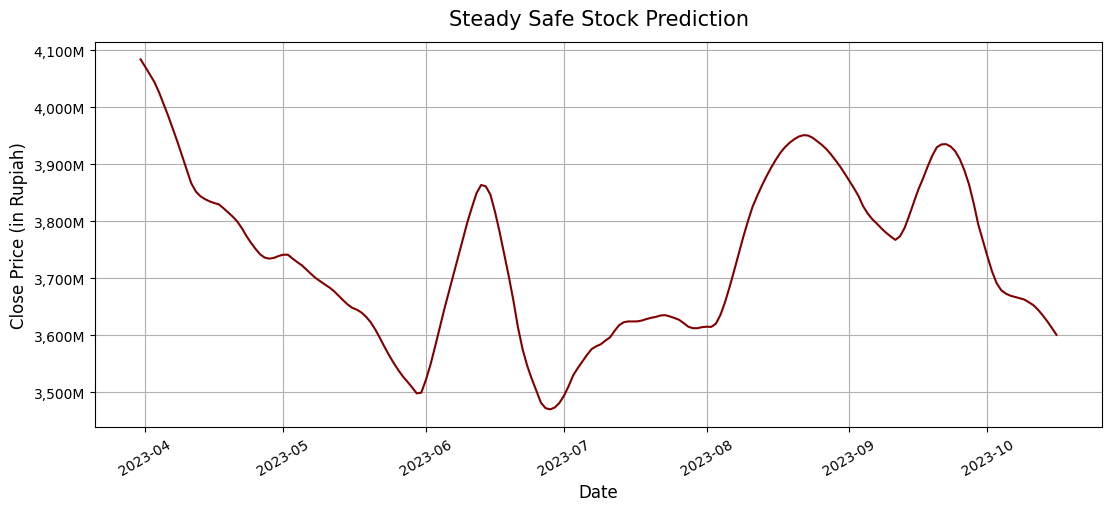

In [220]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Linear - AdaMax

In [221]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='linear'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_linear_adamax.h5')

Epoch 1/10
24/24 [==============================] - 31s 704ms/step - loss: 0.0140 - val_loss: 0.0034
Epoch 2/10
24/24 [==============================] - 13s 550ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 3/10
24/24 [==============================] - 14s 577ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 4/10
24/24 [==============================] - 14s 582ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 5/10
24/24 [==============================] - 14s 564ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 6/10
24/24 [==============================] - 14s 565ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 7/10
24/24 [==============================] - 12s 514ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 8/10
24/24 [==============================] - 13s 541ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 9/10
24/24 [==============================] - 13s 538ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 10/10
24/24 [==============================] - 13s 561ms/step - loss: 0.0025 - val_lo

In [222]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 4s 62ms/step
Mean Absolute Error (MAE): 0.0175408
Mean Absolute Percentage Error (MAPE): 0.04406
Root Mean Squared Error (RMSE): 0.02451
Mean Squared Error (MSE): 0.0006007
R-Squared (R2): 0.404266
T-Statistic 0.9693
P-Value 5.131609214004129e-05
Elapsed Time (min): 13.96


7/7 [==============================] - 0s 63ms/step


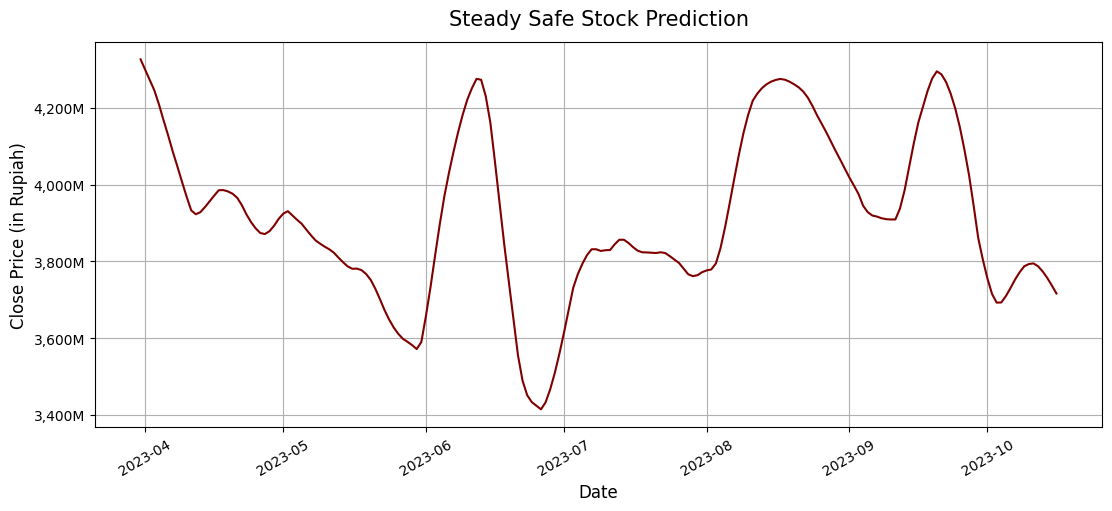

In [223]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Adam

In [224]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_relu_adam.h5')

Epoch 1/10
24/24 [==============================] - 30s 643ms/step - loss: 0.0217 - val_loss: 0.0044
Epoch 2/10
24/24 [==============================] - 12s 491ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 3/10
24/24 [==============================] - 12s 491ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 4/10
24/24 [==============================] - 11s 477ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 5/10
24/24 [==============================] - 11s 444ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 6/10
24/24 [==============================] - 11s 461ms/step - loss: 0.0024 - val_loss: 0.0029
Epoch 7/10
24/24 [==============================] - 12s 490ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 8/10
24/24 [==============================] - 12s 490ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 9/10
24/24 [==============================] - 12s 494ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 10/10
24/24 [==============================] - 12s 502ms/step - loss: 0.0021 - val_lo

In [225]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 64ms/step
Mean Absolute Error (MAE): 0.0164485
Mean Absolute Percentage Error (MAPE): 0.04137
Root Mean Squared Error (RMSE): 0.02312
Mean Squared Error (MSE): 0.0005344
R-Squared (R2): 0.46997
T-Statistic 0.9719
P-Value 0.0001158770828624256
Elapsed Time (min): 13.96


7/7 [==============================] - 0s 63ms/step


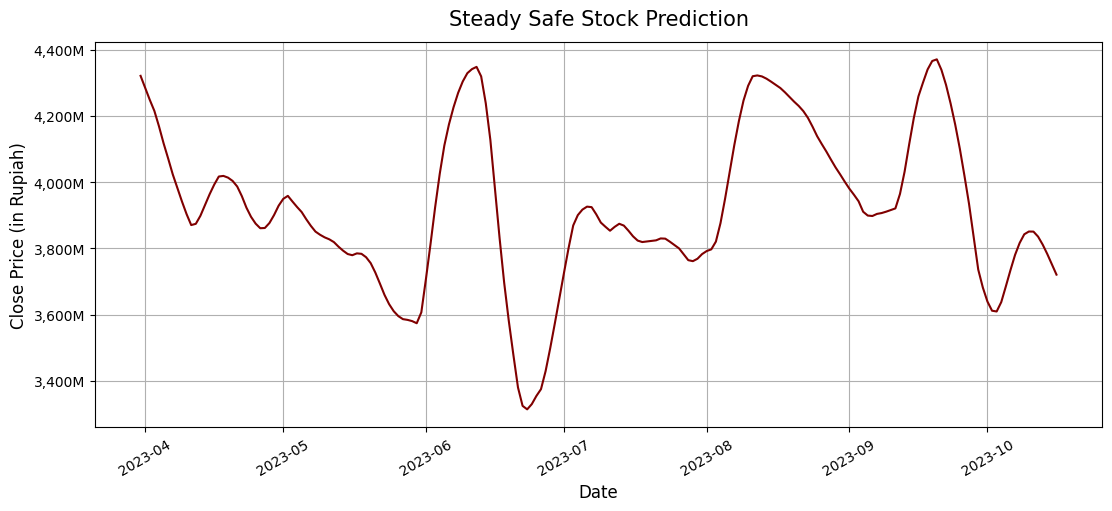

In [226]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaGrad

In [227]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_relu_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 30s 728ms/step - loss: 0.0673 - val_loss: 0.0703
Epoch 2/10
24/24 [==============================] - 14s 578ms/step - loss: 0.0460 - val_loss: 0.0472
Epoch 3/10
24/24 [==============================] - 14s 593ms/step - loss: 0.0366 - val_loss: 0.0344
Epoch 4/10
24/24 [==============================] - 14s 600ms/step - loss: 0.0315 - val_loss: 0.0266
Epoch 5/10
24/24 [==============================] - 15s 642ms/step - loss: 0.0291 - val_loss: 0.0219
Epoch 6/10
24/24 [==============================] - 15s 631ms/step - loss: 0.0273 - val_loss: 0.0187
Epoch 7/10
24/24 [==============================] - 15s 609ms/step - loss: 0.0258 - val_loss: 0.0165
Epoch 8/10
24/24 [==============================] - 15s 610ms/step - loss: 0.0248 - val_loss: 0.0150
Epoch 9/10
24/24 [==============================] - 15s 631ms/step - loss: 0.0242 - val_loss: 0.0139
Epoch 10/10
24/24 [==============================] - 15s 609ms/step - loss: 0.0229 - val_lo

In [228]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 6s 79ms/step
Mean Absolute Error (MAE): 0.112367
Mean Absolute Percentage Error (MAPE): 0.27621
Root Mean Squared Error (RMSE): 0.11577
Mean Squared Error (MSE): 0.0134021
R-Squared (R2): -12.291233
T-Statistic 0.954
P-Value 7.137746820262691e-07
Elapsed Time (min): 13.96


7/7 [==============================] - 1s 84ms/step


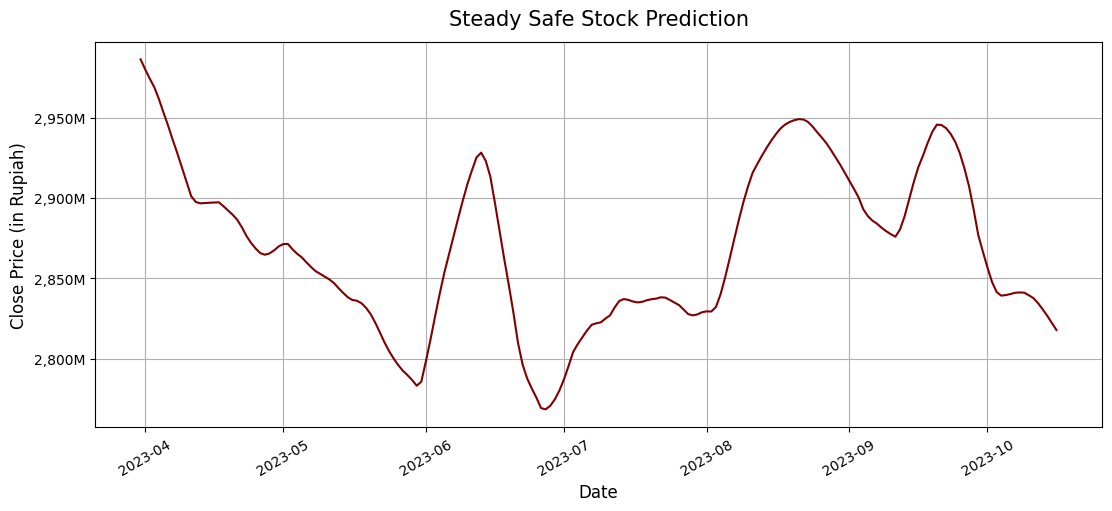

In [229]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - Nadam

In [230]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_relu_nadam.h5')

Epoch 1/10
24/24 [==============================] - 34s 604ms/step - loss: 0.0198 - val_loss: 0.0035
Epoch 2/10
24/24 [==============================] - 14s 580ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 3/10
24/24 [==============================] - 14s 607ms/step - loss: 0.0027 - val_loss: 0.0030
Epoch 4/10
24/24 [==============================] - 15s 613ms/step - loss: 0.0026 - val_loss: 0.0035
Epoch 5/10
24/24 [==============================] - 14s 585ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 6/10
24/24 [==============================] - 15s 616ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 7/10
24/24 [==============================] - 15s 605ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 8/10
24/24 [==============================] - 14s 598ms/step - loss: 0.0021 - val_loss: 0.0027
Epoch 9/10
24/24 [==============================] - 14s 589ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 10/10
24/24 [==============================] - 13s 548ms/step - loss: 0.0019 - val_lo

In [231]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 65ms/step
Mean Absolute Error (MAE): 0.0162764
Mean Absolute Percentage Error (MAPE): 0.04106
Root Mean Squared Error (RMSE): 0.022
Mean Squared Error (MSE): 0.0004839
R-Squared (R2): 0.520062
T-Statistic 0.976
P-Value 0.00046685320558026433
Elapsed Time (min): 13.96


7/7 [==============================] - 1s 72ms/step


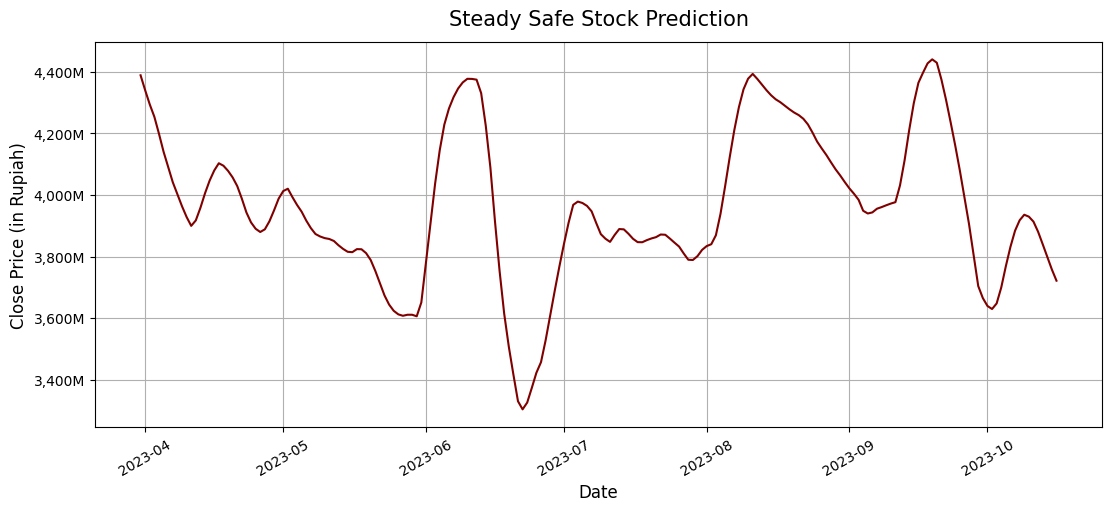

In [232]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - RMSProp

In [233]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_relu_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 32s 738ms/step - loss: 0.0105 - val_loss: 0.0111
Epoch 2/10
24/24 [==============================] - 15s 624ms/step - loss: 0.0043 - val_loss: 0.0039
Epoch 3/10
24/24 [==============================] - 15s 628ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 4/10
24/24 [==============================] - 15s 634ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 5/10
24/24 [==============================] - 15s 606ms/step - loss: 0.0028 - val_loss: 0.0034
Epoch 6/10
24/24 [==============================] - 15s 606ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 7/10
24/24 [==============================] - 14s 587ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 8/10
24/24 [==============================] - 13s 550ms/step - loss: 0.0026 - val_loss: 0.0058
Epoch 9/10
24/24 [==============================] - 15s 626ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 10/10
24/24 [==============================] - 15s 631ms/step - loss: 0.0026 - val_lo

In [234]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 4s 77ms/step
Mean Absolute Error (MAE): 0.0221722
Mean Absolute Percentage Error (MAPE): 0.05678
Root Mean Squared Error (RMSE): 0.02773
Mean Squared Error (MSE): 0.0007687
R-Squared (R2): 0.237682
T-Statistic 0.9716
P-Value 0.00010514121822779998
Elapsed Time (min): 13.96


7/7 [==============================] - 1s 70ms/step


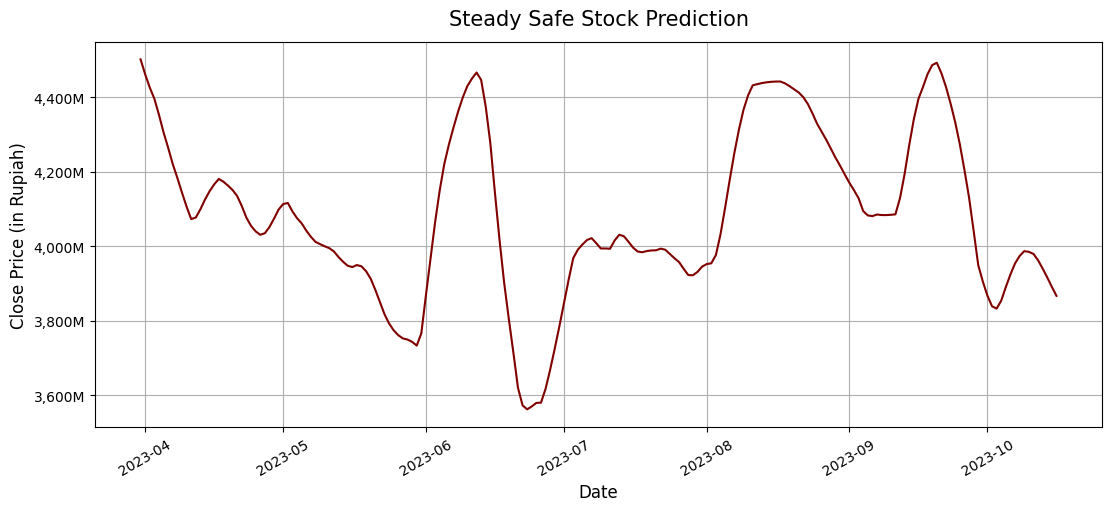

In [235]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaDelta

In [236]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_relu_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 35s 806ms/step - loss: 0.0961 - val_loss: 0.1422
Epoch 2/10
24/24 [==============================] - 14s 589ms/step - loss: 0.0951 - val_loss: 0.1409
Epoch 3/10
24/24 [==============================] - 14s 569ms/step - loss: 0.0944 - val_loss: 0.1395
Epoch 4/10
24/24 [==============================] - 13s 539ms/step - loss: 0.0937 - val_loss: 0.1380
Epoch 5/10
24/24 [==============================] - 12s 516ms/step - loss: 0.0932 - val_loss: 0.1365
Epoch 6/10
24/24 [==============================] - 13s 563ms/step - loss: 0.0919 - val_loss: 0.1350
Epoch 7/10
24/24 [==============================] - 14s 573ms/step - loss: 0.0909 - val_loss: 0.1334
Epoch 8/10
24/24 [==============================] - 14s 567ms/step - loss: 0.0898 - val_loss: 0.1318
Epoch 9/10
24/24 [==============================] - 14s 569ms/step - loss: 0.0888 - val_loss: 0.1302
Epoch 10/10
24/24 [==============================] - 15s 607ms/step - loss: 0.0877 - val_lo

In [237]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 6s 76ms/step
Mean Absolute Error (MAE): 0.3776378
Mean Absolute Percentage Error (MAPE): 0.94037
Root Mean Squared Error (RMSE): 0.37893
Mean Squared Error (MSE): 0.1435843
R-Squared (R2): -141.397044
T-Statistic 0.9401
P-Value 2.7414275294290746e-08
Elapsed Time (min): 13.96


7/7 [==============================] - 1s 68ms/step


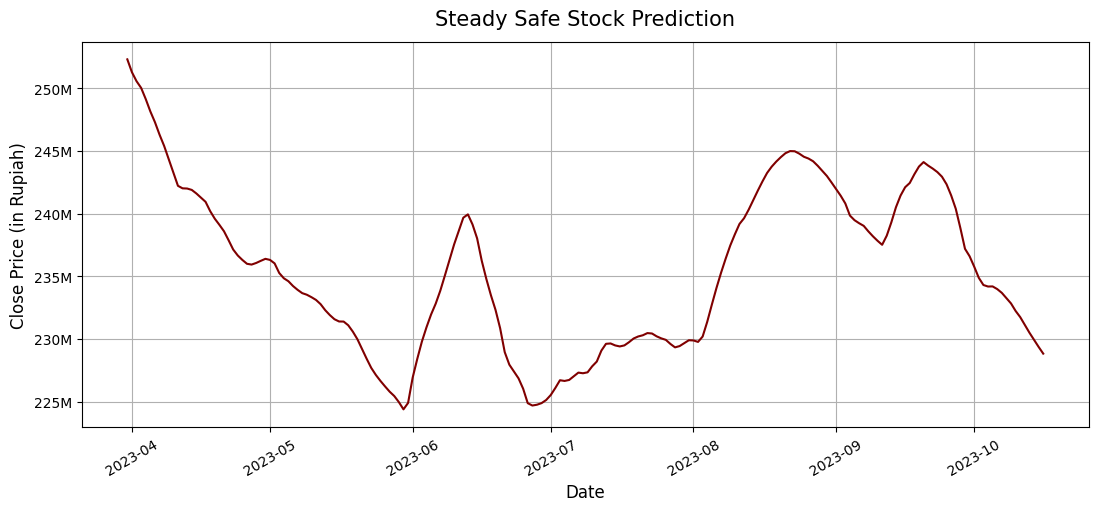

In [238]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - SGD

In [239]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_relu_sgd.h5')

Epoch 1/10
24/24 [==============================] - 34s 730ms/step - loss: 0.0659 - val_loss: 0.0496
Epoch 2/10
24/24 [==============================] - 13s 549ms/step - loss: 0.0388 - val_loss: 0.0262
Epoch 3/10
24/24 [==============================] - 13s 553ms/step - loss: 0.0333 - val_loss: 0.0196
Epoch 4/10
24/24 [==============================] - 15s 618ms/step - loss: 0.0307 - val_loss: 0.0174
Epoch 5/10
24/24 [==============================] - 14s 586ms/step - loss: 0.0289 - val_loss: 0.0159
Epoch 6/10
24/24 [==============================] - 14s 603ms/step - loss: 0.0269 - val_loss: 0.0146
Epoch 7/10
24/24 [==============================] - 14s 589ms/step - loss: 0.0253 - val_loss: 0.0137
Epoch 8/10
24/24 [==============================] - 14s 588ms/step - loss: 0.0234 - val_loss: 0.0131
Epoch 9/10
24/24 [==============================] - 14s 581ms/step - loss: 0.0216 - val_loss: 0.0122
Epoch 10/10
24/24 [==============================] - 14s 592ms/step - loss: 0.0201 - val_lo

In [240]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 4s 69ms/step
Mean Absolute Error (MAE): 0.0989266
Mean Absolute Percentage Error (MAPE): 0.24275
Root Mean Squared Error (RMSE): 0.10255
Mean Squared Error (MSE): 0.0105163
R-Squared (R2): -9.429381
T-Statistic 0.9536
P-Value 6.367395712914004e-07
Elapsed Time (min): 13.96


7/7 [==============================] - 1s 66ms/step


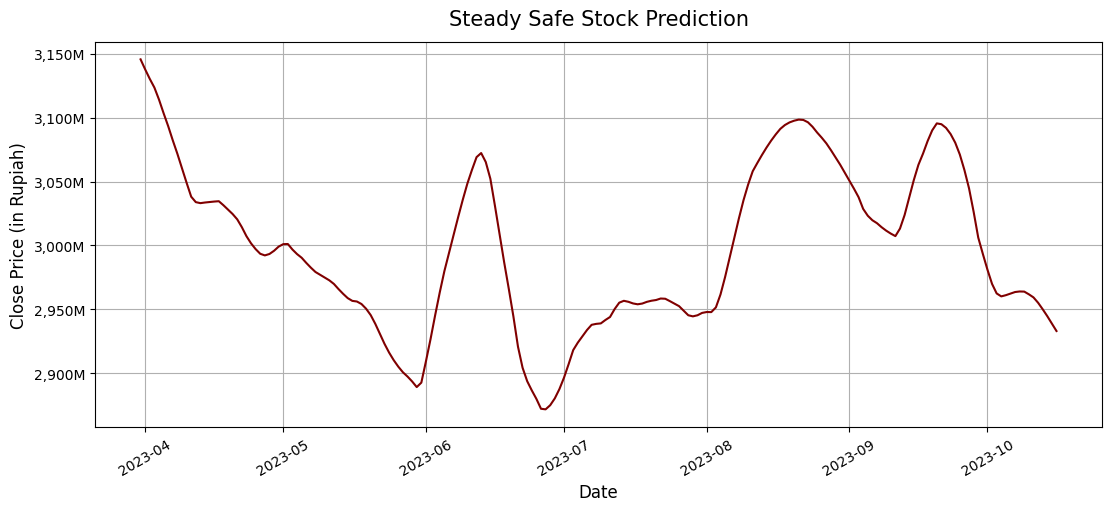

In [241]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## ReLU - AdaMax

In [242]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_relu_adamax.h5')

Epoch 1/10
24/24 [==============================] - 27s 776ms/step - loss: 0.0167 - val_loss: 0.0036
Epoch 2/10
24/24 [==============================] - 14s 580ms/step - loss: 0.0043 - val_loss: 0.0035
Epoch 3/10
24/24 [==============================] - 14s 603ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 4/10
24/24 [==============================] - 15s 628ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 5/10
24/24 [==============================] - 15s 611ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/10
24/24 [==============================] - 15s 637ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 7/10
24/24 [==============================] - 15s 645ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 8/10
24/24 [==============================] - 15s 639ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 9/10
24/24 [==============================] - 15s 611ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 10/10
24/24 [==============================] - 14s 593ms/step - loss: 0.0027 - val_lo

In [243]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 5s 69ms/step
Mean Absolute Error (MAE): 0.0187094
Mean Absolute Percentage Error (MAPE): 0.04648
Root Mean Squared Error (RMSE): 0.02601
Mean Squared Error (MSE): 0.0006764
R-Squared (R2): 0.329208
T-Statistic 0.9675
P-Value 2.9766511943307705e-05
Elapsed Time (min): 13.96


7/7 [==============================] - 1s 74ms/step


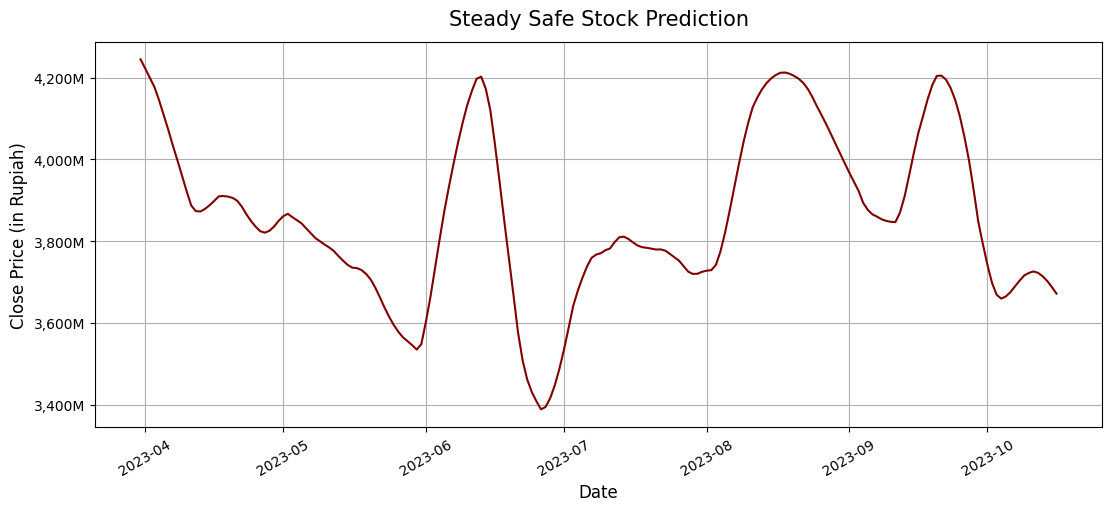

In [244]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Adam

In [245]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_sigmoid_adam.h5')

Epoch 1/10
24/24 [==============================] - 36s 756ms/step - loss: 0.0678 - val_loss: 0.0035
Epoch 2/10
24/24 [==============================] - 14s 590ms/step - loss: 0.0073 - val_loss: 0.0041
Epoch 3/10
24/24 [==============================] - 14s 572ms/step - loss: 0.0040 - val_loss: 0.0034
Epoch 4/10
24/24 [==============================] - 14s 600ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 5/10
24/24 [==============================] - 14s 587ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 6/10
24/24 [==============================] - 14s 576ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 7/10
24/24 [==============================] - 13s 547ms/step - loss: 0.0029 - val_loss: 0.0034
Epoch 8/10
24/24 [==============================] - 14s 591ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 9/10
24/24 [==============================] - 15s 636ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 10/10
24/24 [==============================] - 15s 612ms/step - loss: 0.0026 - val_lo

In [246]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 4s 69ms/step
Mean Absolute Error (MAE): 0.0255065
Mean Absolute Percentage Error (MAPE): 0.06525
Root Mean Squared Error (RMSE): 0.03188
Mean Squared Error (MSE): 0.0010163
R-Squared (R2): -0.007934
T-Statistic 0.9702
P-Value 6.771161133656278e-05
Elapsed Time (min): 13.96


7/7 [==============================] - 1s 69ms/step


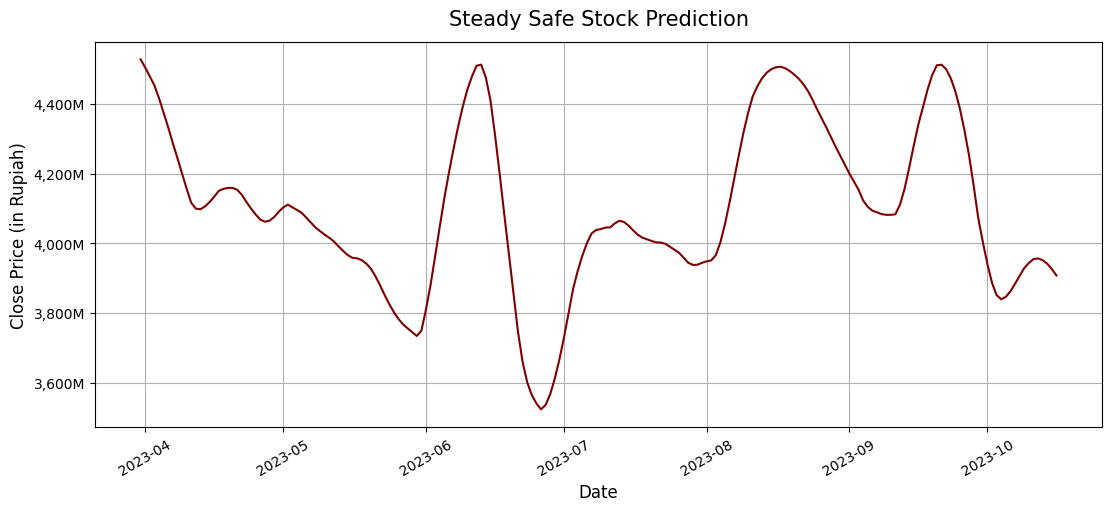

In [247]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaGrad

In [248]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_sigmoid_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 35s 741ms/step - loss: 0.5357 - val_loss: 0.2577
Epoch 2/10
24/24 [==============================] - 14s 603ms/step - loss: 0.3948 - val_loss: 0.1838
Epoch 3/10
24/24 [==============================] - 14s 572ms/step - loss: 0.3178 - val_loss: 0.1370
Epoch 4/10
24/24 [==============================] - 14s 594ms/step - loss: 0.2648 - val_loss: 0.1041
Epoch 5/10
24/24 [==============================] - 15s 626ms/step - loss: 0.2248 - val_loss: 0.0797
Epoch 6/10
24/24 [==============================] - 14s 600ms/step - loss: 0.1937 - val_loss: 0.0613
Epoch 7/10
24/24 [==============================] - 14s 598ms/step - loss: 0.1683 - val_loss: 0.0471
Epoch 8/10
24/24 [==============================] - 15s 614ms/step - loss: 0.1476 - val_loss: 0.0362
Epoch 9/10
24/24 [==============================] - 15s 629ms/step - loss: 0.1305 - val_loss: 0.0277
Epoch 10/10
24/24 [==============================] - 15s 642ms/step - loss: 0.1163 - val_lo

In [249]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 5s 83ms/step
Mean Absolute Error (MAE): 0.0928407
Mean Absolute Percentage Error (MAPE): 0.23908
Root Mean Squared Error (RMSE): 0.09826
Mean Squared Error (MSE): 0.0096551
R-Squared (R2): -8.575217
T-Statistic 0.9523
P-Value 4.601275804816396e-07
Elapsed Time (min): 13.96


7/7 [==============================] - 1s 75ms/step


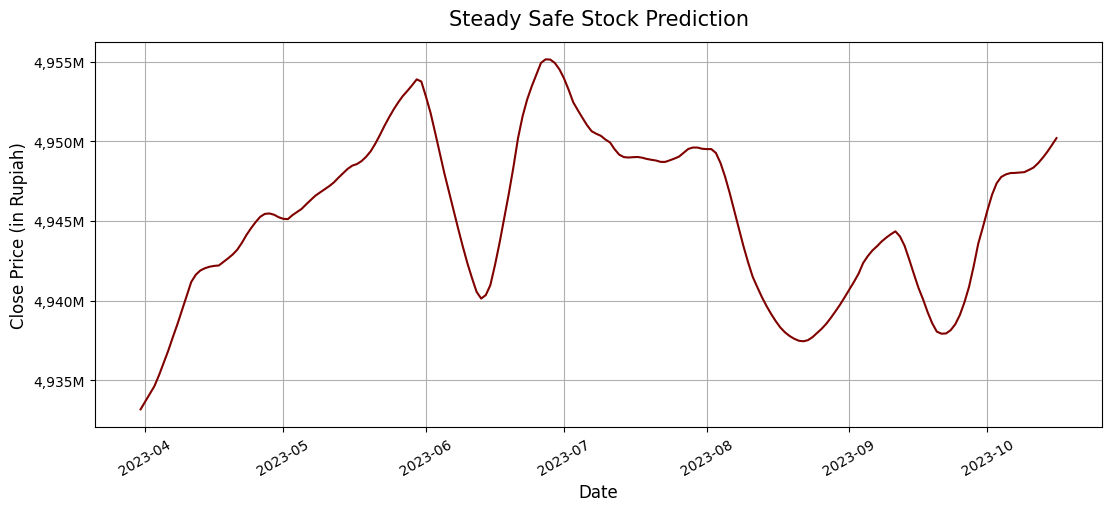

In [250]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - Nadam

In [251]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_sigmoid_nadam.h5')

Epoch 1/10
24/24 [==============================] - 34s 576ms/step - loss: 0.0941 - val_loss: 0.0291
Epoch 2/10
24/24 [==============================] - 12s 482ms/step - loss: 0.0232 - val_loss: 0.0303
Epoch 3/10
24/24 [==============================] - 12s 490ms/step - loss: 0.0064 - val_loss: 0.0038
Epoch 4/10
24/24 [==============================] - 12s 503ms/step - loss: 0.0050 - val_loss: 0.0035
Epoch 5/10
24/24 [==============================] - 12s 508ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 6/10
24/24 [==============================] - 12s 514ms/step - loss: 0.0038 - val_loss: 0.0043
Epoch 7/10
24/24 [==============================] - 13s 528ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 8/10
24/24 [==============================] - 12s 506ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 9/10
24/24 [==============================] - 12s 507ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 10/10
24/24 [==============================] - 12s 509ms/step - loss: 0.0031 - val_lo

In [252]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 84ms/step
Mean Absolute Error (MAE): 0.0192531
Mean Absolute Percentage Error (MAPE): 0.04844
Root Mean Squared Error (RMSE): 0.02692
Mean Squared Error (MSE): 0.0007249
R-Squared (R2): 0.28111
T-Statistic 0.971
P-Value 8.824939141049981e-05
Elapsed Time (min): 13.96


7/7 [==============================] - 0s 52ms/step


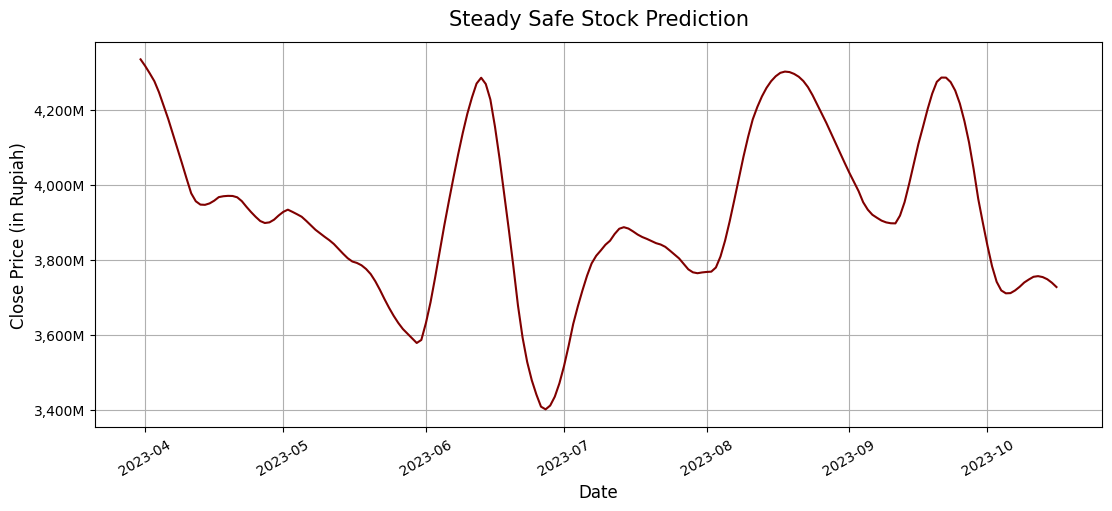

In [253]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - RMSProp

In [254]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_sigmoid_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 20s 517ms/step - loss: 0.1127 - val_loss: 0.0081
Epoch 2/10
24/24 [==============================] - 10s 399ms/step - loss: 0.0202 - val_loss: 0.0143
Epoch 3/10
24/24 [==============================] - 10s 407ms/step - loss: 0.0137 - val_loss: 0.0267
Epoch 4/10
24/24 [==============================] - 11s 441ms/step - loss: 0.0159 - val_loss: 0.0032
Epoch 5/10
24/24 [==============================] - 11s 449ms/step - loss: 0.0109 - val_loss: 0.0126
Epoch 6/10
24/24 [==============================] - 10s 424ms/step - loss: 0.0101 - val_loss: 0.0053
Epoch 7/10
24/24 [==============================] - 11s 439ms/step - loss: 0.0080 - val_loss: 0.0150
Epoch 8/10
24/24 [==============================] - 11s 445ms/step - loss: 0.0083 - val_loss: 0.0029
Epoch 9/10
24/24 [==============================] - 10s 435ms/step - loss: 0.0073 - val_loss: 0.0148
Epoch 10/10
24/24 [==============================] - 11s 452ms/step - loss: 0.0062 - val_lo

In [255]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 55ms/step
Mean Absolute Error (MAE): 0.0197245
Mean Absolute Percentage Error (MAPE): 0.04853
Root Mean Squared Error (RMSE): 0.02667
Mean Squared Error (MSE): 0.0007114
R-Squared (R2): 0.29446
T-Statistic 0.9655
P-Value 1.608828461030498e-05
Elapsed Time (min): 13.96


7/7 [==============================] - 0s 56ms/step


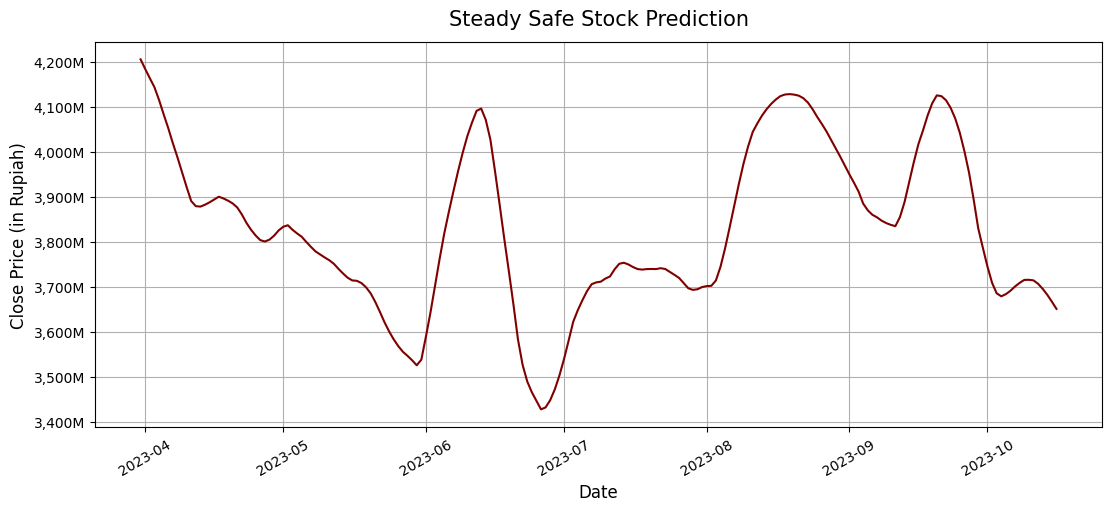

In [256]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaDelta

In [257]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_sigmoid_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 21s 497ms/step - loss: 1.4046 - val_loss: 1.6893
Epoch 2/10
24/24 [==============================] - 10s 401ms/step - loss: 1.4017 - val_loss: 1.6855
Epoch 3/10
24/24 [==============================] - 9s 390ms/step - loss: 1.3985 - val_loss: 1.6816
Epoch 4/10
24/24 [==============================] - 9s 388ms/step - loss: 1.3950 - val_loss: 1.6776
Epoch 5/10
24/24 [==============================] - 9s 389ms/step - loss: 1.3922 - val_loss: 1.6736
Epoch 6/10
24/24 [==============================] - 9s 378ms/step - loss: 1.3890 - val_loss: 1.6694
Epoch 7/10
24/24 [==============================] - 9s 380ms/step - loss: 1.3855 - val_loss: 1.6652
Epoch 8/10
24/24 [==============================] - 9s 377ms/step - loss: 1.3821 - val_loss: 1.6609
Epoch 9/10
24/24 [==============================] - 9s 395ms/step - loss: 1.3786 - val_loss: 1.6565
Epoch 10/10
24/24 [==============================] - 9s 391ms/step - loss: 1.3748 - val_loss: 1.65

In [258]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 5s 68ms/step
Mean Absolute Error (MAE): 1.3102722
Mean Absolute Percentage Error (MAPE): 3.27805
Root Mean Squared Error (RMSE): 1.31064
Mean Squared Error (MSE): 1.7177831
R-Squared (R2): -1702.5789
T-Statistic 0.9456
P-Value 9.402361200727682e-08
Elapsed Time (min): 13.96


7/7 [==============================] - 0s 64ms/step


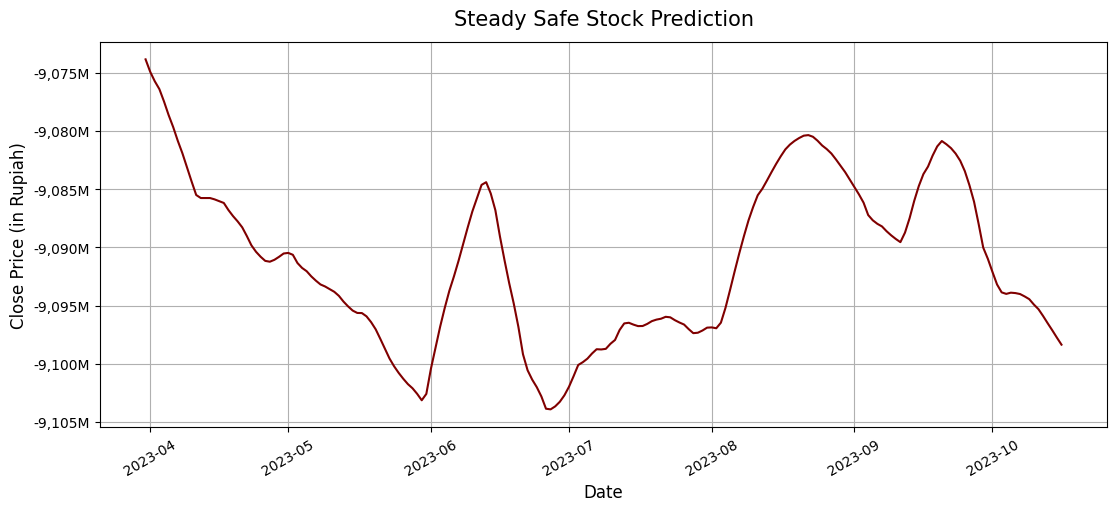

In [259]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - SGD

In [260]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_sigmoid_sgd.h5')

Epoch 1/10
24/24 [==============================] - 17s 403ms/step - loss: 0.0590 - val_loss: 0.0236
Epoch 2/10
24/24 [==============================] - 9s 369ms/step - loss: 0.0406 - val_loss: 0.0230
Epoch 3/10
24/24 [==============================] - 8s 348ms/step - loss: 0.0400 - val_loss: 0.0219
Epoch 4/10
24/24 [==============================] - 9s 381ms/step - loss: 0.0394 - val_loss: 0.0247
Epoch 5/10
24/24 [==============================] - 9s 389ms/step - loss: 0.0389 - val_loss: 0.0205
Epoch 6/10
24/24 [==============================] - 9s 377ms/step - loss: 0.0382 - val_loss: 0.0215
Epoch 7/10
24/24 [==============================] - 9s 376ms/step - loss: 0.0377 - val_loss: 0.0231
Epoch 8/10
24/24 [==============================] - 9s 382ms/step - loss: 0.0371 - val_loss: 0.0206
Epoch 9/10
24/24 [==============================] - 9s 380ms/step - loss: 0.0366 - val_loss: 0.0213
Epoch 10/10
24/24 [==============================] - 9s 386ms/step - loss: 0.0360 - val_loss: 0.024

In [261]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 4s 65ms/step
Mean Absolute Error (MAE): 0.1618589
Mean Absolute Percentage Error (MAPE): 0.39961
Root Mean Squared Error (RMSE): 0.16475
Mean Squared Error (MSE): 0.0271439
R-Squared (R2): -25.919481
T-Statistic 0.9548
P-Value 8.592588187639194e-07
Elapsed Time (min): 13.96


7/7 [==============================] - 1s 62ms/step


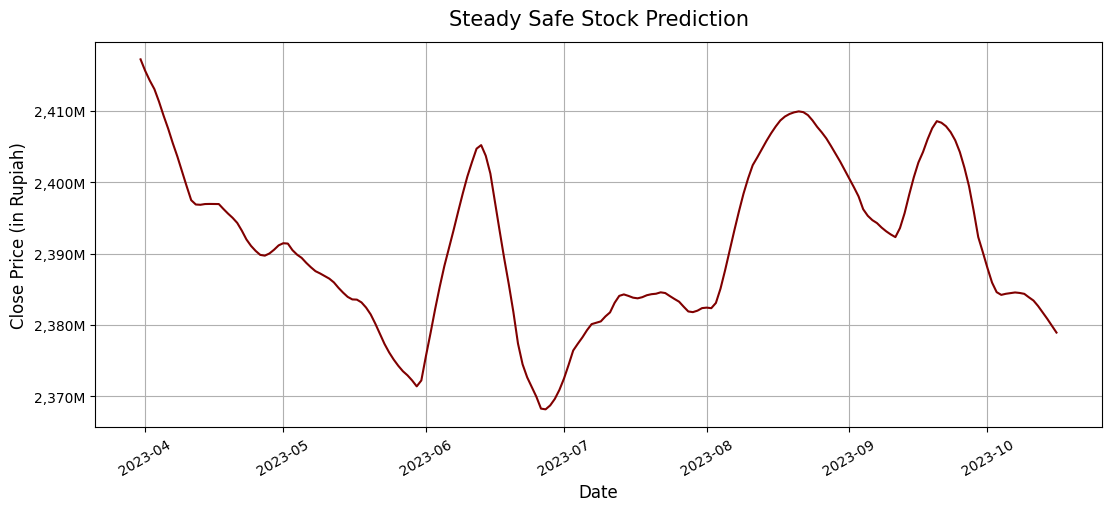

In [262]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Sigmoid - AdaMax

In [263]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_sigmoid_adamax.h5')

Epoch 1/10
24/24 [==============================] - 27s 457ms/step - loss: 0.0226 - val_loss: 0.0038
Epoch 2/10
24/24 [==============================] - 8s 347ms/step - loss: 0.0047 - val_loss: 0.0035
Epoch 3/10
24/24 [==============================] - 8s 334ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 4/10
24/24 [==============================] - 9s 387ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 5/10
24/24 [==============================] - 9s 359ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 6/10
24/24 [==============================] - 9s 389ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 7/10
24/24 [==============================] - 10s 399ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 8/10
24/24 [==============================] - 10s 431ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 9/10
24/24 [==============================] - 11s 468ms/step - loss: 0.0026 - val_loss: 0.0030
Epoch 10/10
24/24 [==============================] - 12s 488ms/step - loss: 0.0024 - val_loss: 0

In [264]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 4s 70ms/step
Mean Absolute Error (MAE): 0.0183921
Mean Absolute Percentage Error (MAPE): 0.04623
Root Mean Squared Error (RMSE): 0.02572
Mean Squared Error (MSE): 0.0006617
R-Squared (R2): 0.343814
T-Statistic 0.9683
P-Value 3.803609433816746e-05
Elapsed Time (min): 13.96


7/7 [==============================] - 1s 69ms/step


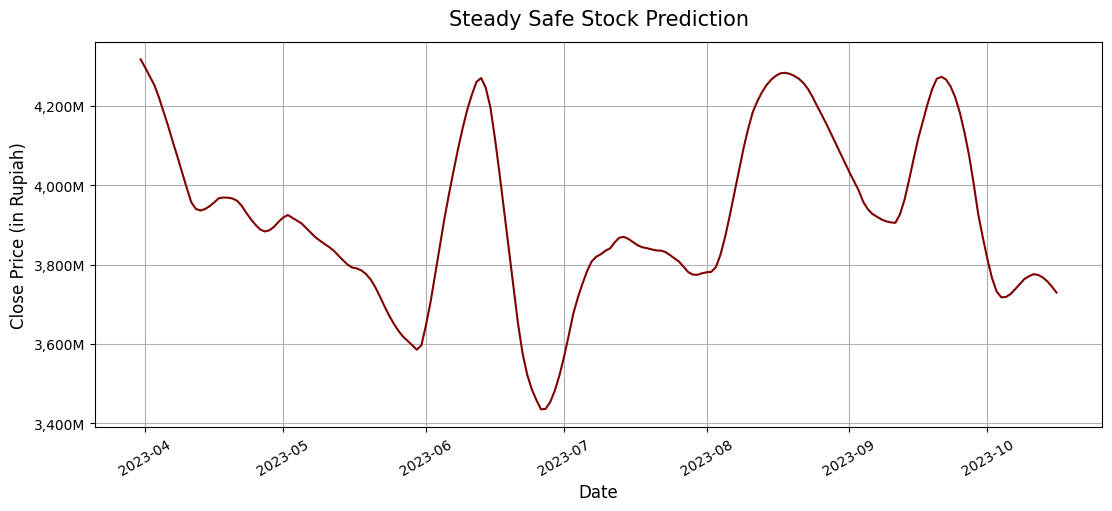

In [265]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Adam

In [266]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_tanh_adam.h5')

Epoch 1/10
24/24 [==============================] - 37s 645ms/step - loss: 0.0149 - val_loss: 0.0029
Epoch 2/10
24/24 [==============================] - 11s 457ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 3/10
24/24 [==============================] - 10s 409ms/step - loss: 0.0025 - val_loss: 0.0030
Epoch 4/10
24/24 [==============================] - 9s 379ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 5/10
24/24 [==============================] - 10s 415ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 6/10
24/24 [==============================] - 11s 439ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 7/10
24/24 [==============================] - 11s 456ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 8/10
24/24 [==============================] - 11s 466ms/step - loss: 0.0020 - val_loss: 0.0026
Epoch 9/10
24/24 [==============================] - 11s 454ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 10/10
24/24 [==============================] - 10s 437ms/step - loss: 0.0018 - val_los

In [267]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 5s 75ms/step
Mean Absolute Error (MAE): 0.017769
Mean Absolute Percentage Error (MAPE): 0.04397
Root Mean Squared Error (RMSE): 0.02418
Mean Squared Error (MSE): 0.0005849
R-Squared (R2): 0.419944
T-Statistic 0.9743
P-Value 0.0002546297328080982
Elapsed Time (min): 13.96


7/7 [==============================] - 1s 73ms/step


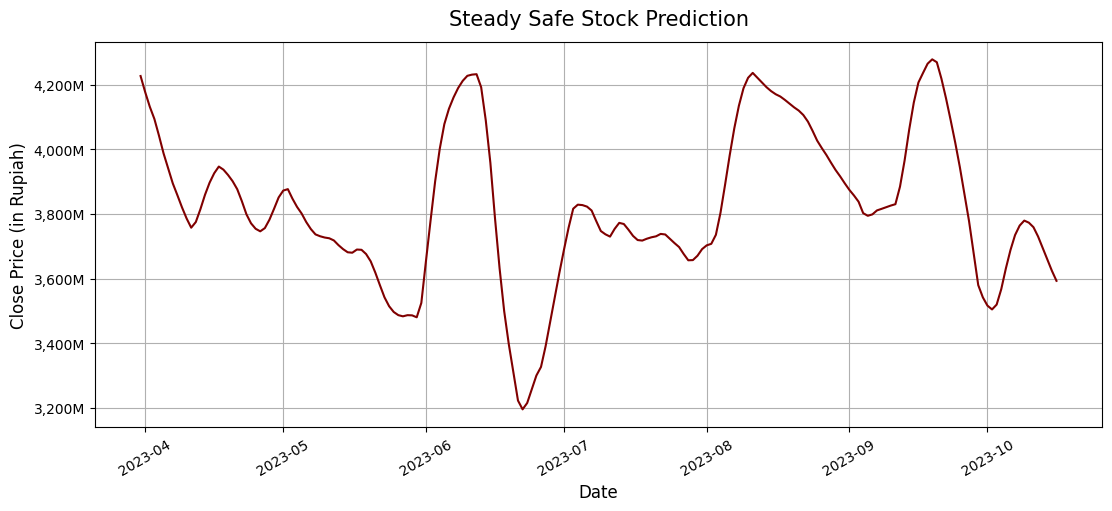

In [268]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaGrad

In [269]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adagrad')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_tanh_adagrad.h5')

Epoch 1/10
24/24 [==============================] - 36s 643ms/step - loss: 0.0676 - val_loss: 0.0559
Epoch 2/10
24/24 [==============================] - 11s 454ms/step - loss: 0.0398 - val_loss: 0.0307
Epoch 3/10
24/24 [==============================] - 10s 423ms/step - loss: 0.0333 - val_loss: 0.0213
Epoch 4/10
24/24 [==============================] - 9s 394ms/step - loss: 0.0299 - val_loss: 0.0172
Epoch 5/10
24/24 [==============================] - 11s 449ms/step - loss: 0.0279 - val_loss: 0.0150
Epoch 6/10
24/24 [==============================] - 10s 436ms/step - loss: 0.0264 - val_loss: 0.0137
Epoch 7/10
24/24 [==============================] - 11s 451ms/step - loss: 0.0244 - val_loss: 0.0126
Epoch 8/10
24/24 [==============================] - 11s 463ms/step - loss: 0.0231 - val_loss: 0.0117
Epoch 9/10
24/24 [==============================] - 11s 456ms/step - loss: 0.0215 - val_loss: 0.0109
Epoch 10/10
24/24 [==============================] - 11s 456ms/step - loss: 0.0200 - val_los

In [270]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 4s 76ms/step
Mean Absolute Error (MAE): 0.0955625
Mean Absolute Percentage Error (MAPE): 0.23419
Root Mean Squared Error (RMSE): 0.09949
Mean Squared Error (MSE): 0.0098988
R-Squared (R2): -8.816969
T-Statistic 0.9554
P-Value 1.0176373734793742e-06
Elapsed Time (min): 13.96


7/7 [==============================] - 1s 75ms/step


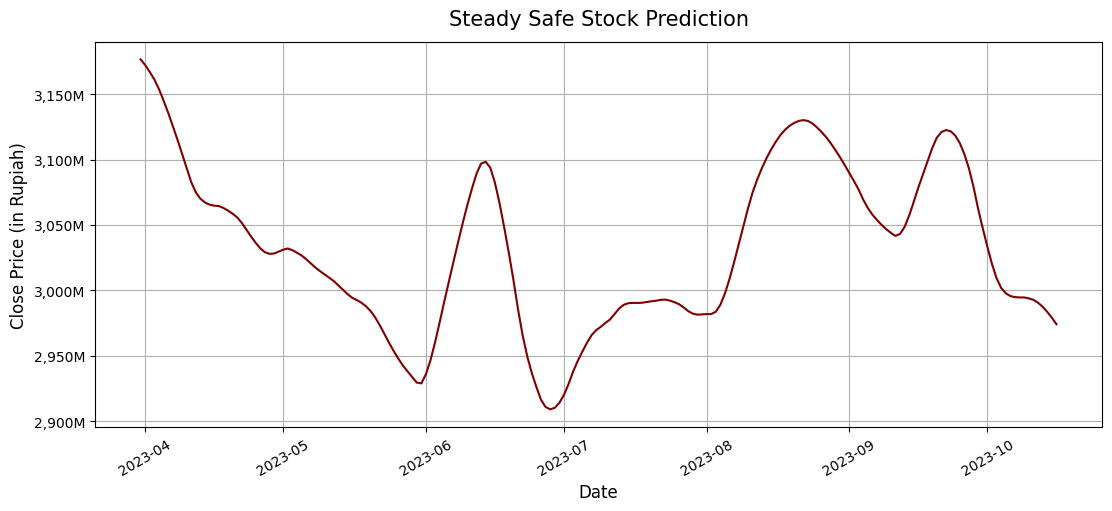

In [271]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - Nadam

In [272]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='nadam')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_tanh_nadam.h5')

Epoch 1/10
24/24 [==============================] - 36s 684ms/step - loss: 0.0159 - val_loss: 0.0036
Epoch 2/10
24/24 [==============================] - 10s 422ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 3/10
24/24 [==============================] - 10s 406ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 4/10
24/24 [==============================] - 9s 384ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 5/10
24/24 [==============================] - 9s 362ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 6/10
24/24 [==============================] - 10s 402ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 7/10
24/24 [==============================] - 10s 406ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 8/10
24/24 [==============================] - 10s 415ms/step - loss: 0.0021 - val_loss: 0.0026
Epoch 9/10
24/24 [==============================] - 10s 415ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 10/10
24/24 [==============================] - 10s 431ms/step - loss: 0.0018 - val_loss

In [273]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 5s 72ms/step
Mean Absolute Error (MAE): 0.0179356
Mean Absolute Percentage Error (MAPE): 0.04425
Root Mean Squared Error (RMSE): 0.02413
Mean Squared Error (MSE): 0.0005823
R-Squared (R2): 0.422513
T-Statistic 0.977
P-Value 0.000648120476398617
Elapsed Time (min): 13.96


7/7 [==============================] - 1s 72ms/step


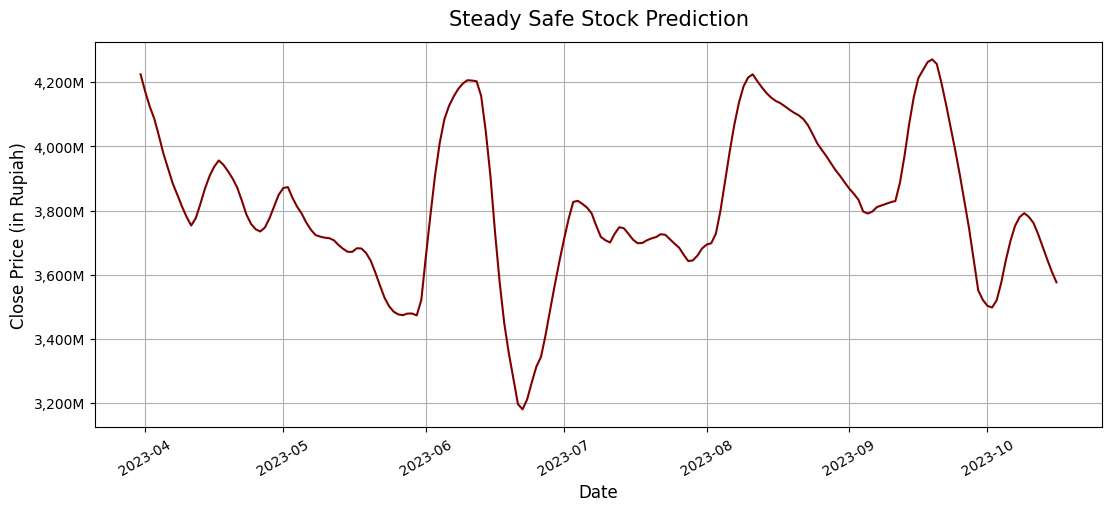

In [274]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - RMSProp

In [275]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='rmsprop')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_tanh_rmsprop.h5')

Epoch 1/10
24/24 [==============================] - 29s 568ms/step - loss: 0.0129 - val_loss: 0.0067
Epoch 2/10
24/24 [==============================] - 9s 396ms/step - loss: 0.0041 - val_loss: 0.0052
Epoch 3/10
24/24 [==============================] - 10s 406ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 4/10
24/24 [==============================] - 10s 407ms/step - loss: 0.0033 - val_loss: 0.0062
Epoch 5/10
24/24 [==============================] - 9s 355ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 6/10
24/24 [==============================] - 7s 309ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 7/10
24/24 [==============================] - 7s 301ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 8/10
24/24 [==============================] - 8s 328ms/step - loss: 0.0026 - val_loss: 0.0044
Epoch 9/10
24/24 [==============================] - 9s 363ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 10/10
24/24 [==============================] - 9s 395ms/step - loss: 0.0022 - val_loss: 0.0

In [276]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 3s 58ms/step
Mean Absolute Error (MAE): 0.0194867
Mean Absolute Percentage Error (MAPE): 0.04968
Root Mean Squared Error (RMSE): 0.0251
Mean Squared Error (MSE): 0.0006299
R-Squared (R2): 0.3753
T-Statistic 0.9717
P-Value 0.0001095109255402349
Elapsed Time (min): 13.96


7/7 [==============================] - 0s 62ms/step


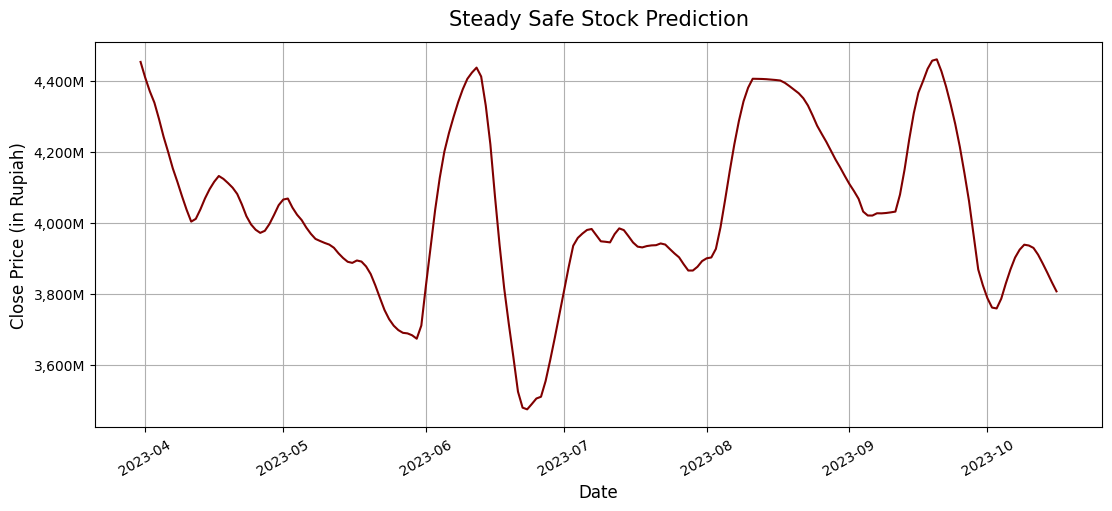

In [277]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaDelta

In [278]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adadelta')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_tanh_adadelta.h5')

Epoch 1/10
24/24 [==============================] - 19s 456ms/step - loss: 0.1051 - val_loss: 0.1553
Epoch 2/10
24/24 [==============================] - 7s 302ms/step - loss: 0.1035 - val_loss: 0.1523
Epoch 3/10
24/24 [==============================] - 8s 315ms/step - loss: 0.1013 - val_loss: 0.1494
Epoch 4/10
24/24 [==============================] - 7s 301ms/step - loss: 0.1000 - val_loss: 0.1464
Epoch 5/10
24/24 [==============================] - 8s 315ms/step - loss: 0.0978 - val_loss: 0.1434
Epoch 6/10
24/24 [==============================] - 7s 303ms/step - loss: 0.0961 - val_loss: 0.1405
Epoch 7/10
24/24 [==============================] - 7s 304ms/step - loss: 0.0938 - val_loss: 0.1375
Epoch 8/10
24/24 [==============================] - 7s 301ms/step - loss: 0.0919 - val_loss: 0.1346
Epoch 9/10
24/24 [==============================] - 7s 313ms/step - loss: 0.0904 - val_loss: 0.1316
Epoch 10/10
24/24 [==============================] - 8s 315ms/step - loss: 0.0883 - val_loss: 0.128

In [279]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 65ms/step
Mean Absolute Error (MAE): 0.3783963
Mean Absolute Percentage Error (MAPE): 0.94239
Root Mean Squared Error (RMSE): 0.37963
Mean Squared Error (MSE): 0.1441217
R-Squared (R2): -141.929984
T-Statistic 0.9734
P-Value 0.0001922320225276053
Elapsed Time (min): 13.96


7/7 [==============================] - 0s 46ms/step


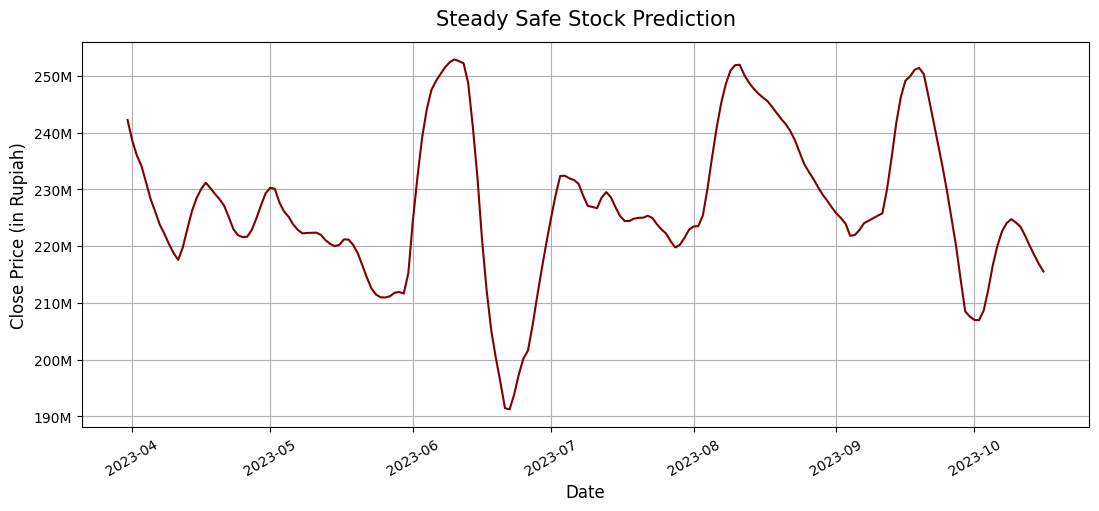

In [280]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - SGD

In [281]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='sgd')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_tanh_sgd.h5')

Epoch 1/10
24/24 [==============================] - 16s 398ms/step - loss: 0.0438 - val_loss: 0.0202
Epoch 2/10
24/24 [==============================] - 8s 332ms/step - loss: 0.0302 - val_loss: 0.0157
Epoch 3/10
24/24 [==============================] - 8s 324ms/step - loss: 0.0250 - val_loss: 0.0147
Epoch 4/10
24/24 [==============================] - 8s 325ms/step - loss: 0.0217 - val_loss: 0.0103
Epoch 5/10
24/24 [==============================] - 8s 327ms/step - loss: 0.0176 - val_loss: 0.0098
Epoch 6/10
24/24 [==============================] - 8s 332ms/step - loss: 0.0152 - val_loss: 0.0085
Epoch 7/10
24/24 [==============================] - 8s 321ms/step - loss: 0.0122 - val_loss: 0.0072
Epoch 8/10
24/24 [==============================] - 8s 318ms/step - loss: 0.0110 - val_loss: 0.0058
Epoch 9/10
24/24 [==============================] - 8s 315ms/step - loss: 0.0082 - val_loss: 0.0052
Epoch 10/10
24/24 [==============================] - 8s 334ms/step - loss: 0.0075 - val_loss: 0.004

In [282]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 43ms/step
Mean Absolute Error (MAE): 0.0374968
Mean Absolute Percentage Error (MAPE): 0.09075
Root Mean Squared Error (RMSE): 0.0436
Mean Squared Error (MSE): 0.0019013
R-Squared (R2): -0.885584
T-Statistic 0.9454
P-Value 8.874419421545099e-08
Elapsed Time (min): 13.96


7/7 [==============================] - 0s 51ms/step


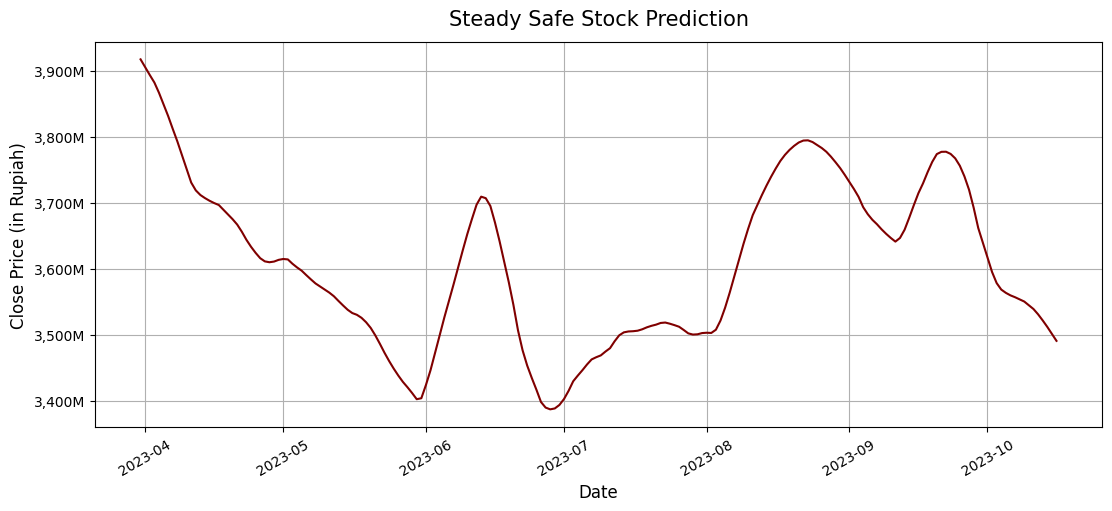

In [283]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Tanh - AdaMax

In [284]:
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='tanh'))
model.add(Dense(1))

# compile the model
model.compile(loss='mean_squared_error', optimizer='adamax')
# train the model
model.fit(X_train, y_train, 
          epochs=10, batch_size=100, verbose=1, validation_split=0.1)
model.summary()
model.save('models/safe_tanh_adamax.h5')

Epoch 1/10
24/24 [==============================] - 15s 344ms/step - loss: 0.0120 - val_loss: 0.0034
Epoch 2/10
24/24 [==============================] - 7s 290ms/step - loss: 0.0033 - val_loss: 0.0029
Epoch 3/10
24/24 [==============================] - 7s 313ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 4/10
24/24 [==============================] - 8s 321ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 5/10
24/24 [==============================] - 7s 304ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 6/10
24/24 [==============================] - 7s 277ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 7/10
24/24 [==============================] - 6s 253ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 8/10
24/24 [==============================] - 6s 264ms/step - loss: 0.0024 - val_loss: 0.0028
Epoch 9/10
24/24 [==============================] - 6s 252ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 10/10
24/24 [==============================] - 6s 257ms/step - loss: 0.0022 - val_loss: 0.002

In [285]:
# Make predictions on the test data
predicted_data = model.predict(X_test)

# Perform t-test
stat, p = stats.shapiro(predicted_data)

# Evaluate the model
mape = round(metrics.mean_absolute_percentage_error(y_test, predicted_data), 5)
mae = round(metrics.mean_absolute_error(y_test, predicted_data), 7)
mse = round(metrics.mean_squared_error(y_test, predicted_data), 7)
rmse = round(math.sqrt(mse), 5)
r2 = round(metrics.r2_score(y_test, predicted_data), 6)
elapsed_time = round(end_time - start_time, 2)

# Print the evaluation metrics
print('Mean Absolute Error (MAE):', mae)
print('Mean Absolute Percentage Error (MAPE):', mape)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Squared Error (MSE):', mse)
print('R-Squared (R2):', r2)
print('T-Statistic', round(stat,4))
print('P-Value', p)
print('Elapsed Time (min):', elapsed_time)

8/8 [==============================] - 2s 43ms/step
Mean Absolute Error (MAE): 0.0172597
Mean Absolute Percentage Error (MAPE): 0.04333
Root Mean Squared Error (RMSE): 0.02401
Mean Squared Error (MSE): 0.0005767
R-Squared (R2): 0.428056
T-Statistic 0.9683
P-Value 3.720310269272886e-05
Elapsed Time (min): 13.96


7/7 [==============================] - 0s 43ms/step


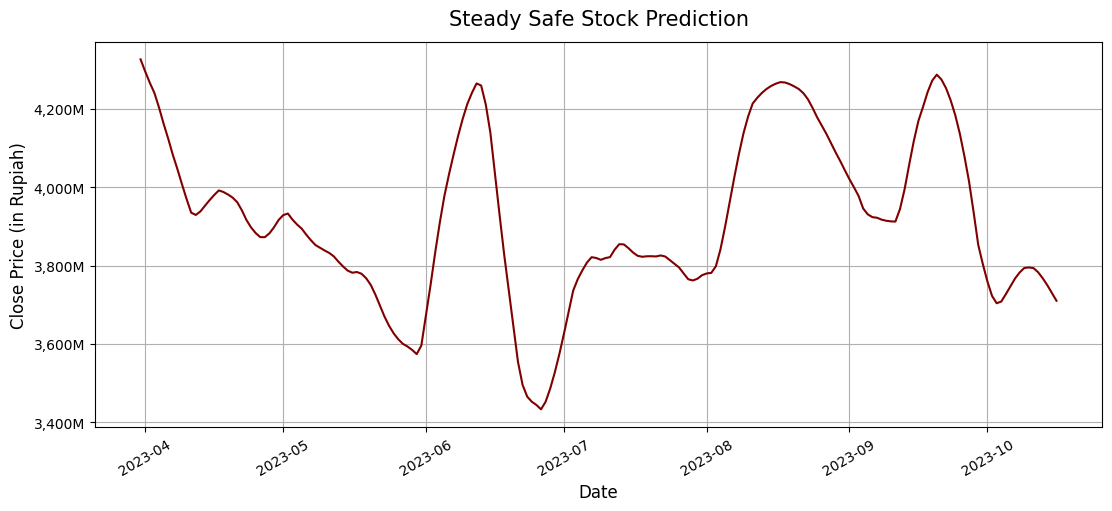

In [286]:
#prediction of LSTM for forecast 6 months ahead
num = 200
X_Predict = X_test[-num:]
Forecast = model.predict(X_Predict)
#create timeseries from the last date
date = np.array(df_safe.index) 
time = pd.date_range(date[len(date) - 1], periods = num, freq = 'd')
#adding the predicted values to dateframe
df_predict = pd.DataFrame(Forecast, index = time)
df_predict.columns = ['Forecast']

# Define the formatter function
def millions(x, pos):
    return '{:,.0f}M'.format(x*10000)
#visualize forecast prediction from close price
plt.figure(figsize=(13,5))
plt.plot(df_predict, color='maroon')
plt.title('Steady Safe Stock Prediction', fontsize = 15, pad = 12)
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Close Price (in Rupiah)', fontsize = 12)
plt.grid(True)
plt.xticks(rotation=30)
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(millions))
plt.show()

## Comparison LSTM Model based on Activation and Optimizer Parameter

In [296]:
# Define the activation functions and optimizers to be tested
activations = ['linear', 'relu', 'tanh', 'sigmoid']
optimizers = ['adam', 'adagrad', 'nadam', 'rmsprop', 'adadelta', 'sgd', 'adamax']

# Generate all possible combinations of activation functions and optimizers
combinations = list(itertools.product(activations, optimizers))

# Define a function to build and train an LSTM model with a given activation function and optimizer
def build_model(activations, optimizers):
    model = Sequential()
    model.add(LSTM(128, input_shape=(sequence_length, num_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation=activations))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizers)
    model.fit(X_train, y_train, batch_size=100, epochs=10, validation_split=0.1, verbose=0)
    return model

# Train and evaluate the models for all possible combinations of activation functions and optimizers
results = []
for activations, optimizers in combinations:
    print(f'Training model with {activations} activation and {optimizers} optimizer')
    start_time = time.time()
    model = build_model(activations, optimizers)
    end_time = time.time()
    preds = model.predict(X_test)
    stat, p = stats.shapiro(preds)
    mape = round(metrics.mean_absolute_percentage_error(y_test, preds), 5)
    mae = round(metrics.mean_absolute_error(y_test, preds), 5)
    mse = round(metrics.mean_squared_error(y_test, preds), 5)
    rmse = round(math.sqrt(mse), 5)
    r2 = round(metrics.r2_score(y_test, preds), 2)
    elapsed_time = round(end_time - start_time, 2)
    results.append([activations, optimizers, mape, mae, mse, rmse, r2, elapsed_time, stat, p])

# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 
                                           'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])

Training model with linear activation and adam optimizer
8/8 [==============================] - 2s 36ms/step
Training model with linear activation and adagrad optimizer
8/8 [==============================] - 2s 43ms/step
Training model with linear activation and nadam optimizer
8/8 [==============================] - 2s 38ms/step
Training model with linear activation and rmsprop optimizer
8/8 [==============================] - 2s 37ms/step
Training model with linear activation and adadelta optimizer
8/8 [==============================] - 2s 54ms/step
Training model with linear activation and sgd optimizer
8/8 [==============================] - 2s 46ms/step
Training model with linear activation and adamax optimizer
8/8 [==============================] - 2s 38ms/step
Training model with relu activation and adam optimizer
8/8 [==============================] - 2s 41ms/step
Training model with relu activation and adagrad optimizer
8/8 [==============================] - 2s 39ms/step
Training

In [297]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get several LSTM model evaluation 
df_pivot_result.sort_values(by=['Activation', 'Optimizer'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
linear     adadelta                71.68  0.36963   0.92035  0.13758   
           adagrad                 68.56  0.11105   0.27295  0.01309   
           adam                    68.72  0.01910   0.04863  0.00058   
           adamax                  67.30  0.02011   0.05132  0.00071   
           nadam                   73.79  0.01797   0.04558  0.00053   
           rmsprop                 68.94  0.01776   0.04395  0.00058   
           sgd                     73.04  0.04839   0.11749  0.00290   
relu       adadelta                65.27  0.35112   0.87412  0.12420   
           adagrad                 68.12  0.10694   0.26258  0.01222   
           adam                    68.26  0.01562   0.03895  0.00050   
           adamax                  66.78  0.02538   0.06229  0.00103   
           nadam                   75.93  0.01763   0.04475  0.00055   
           rmsprop                 76.49  0.02179   0.05371  0.00079   
           sgd                     67.64  0.02294   0.05573  0.00091   
sigmoid    adadelta                86.43  0.17086   0.42210  0.03016   
           adagrad                 76.25  0.48345   1.20597  0.23459   
           adam                    69.05  0.02390   0.06117  0.00095   
           adamax                  75.90  0.02030   0.05088  0.00074   
           nadam                   79.44  0.01534   0.03838  0.00046   
           rmsprop                 80.57  0.02072   0.05281  0.00077   
           sgd                     84.29  0.14646   0.36097  0.02241   
tanh       adadelta                71.68  0.32404   0.80618  0.10593   
           adagrad                 70.30  0.10336   0.25361  0.01147   
           adam                    65.63  0.01888   0.04651  0.00062   
           adamax                  71.45  0.02006   0.04957  0.00072   
           nadam                   81.09  0.01581   0.03923  0.00049   
           rmsprop                 75.50  0.01678   0.04256  0.00052   
           sgd                     69.07  0.02445   0.05926  0.00101   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
linear     adadelta   6.423745e-08        -135.44   0.37092     0.943973  
           adagrad    5.245453e-06         -11.98   0.11441     0.961557  
           adam       4.674333e-04           0.42   0.02408     0.976040  
           adamax     3.429695e-05           0.29   0.02665     0.967999  
           nadam      4.319182e-04           0.47   0.02302     0.975812  
           rmsprop    1.091001e-04           0.42   0.02408     0.971687  
           sgd        1.214196e-07          -1.87   0.05385     0.946747  
relu       adadelta   2.607370e-06        -122.17   0.35242     0.959005  
           adagrad    6.037497e-07         -11.12   0.11054     0.953380  
           adam       1.972734e-04           0.51   0.02236     0.973496  
           adamax     1.242457e-05          -0.02   0.03209     0.964588  
           nadam      2.299613e-04           0.45   0.02345     0.973956  
           rmsprop    7.039866e-05           0.22   0.02811     0.970315  
           sgd        3.100160e-07           0.10   0.03017     0.950684  
sigmoid    adadelta   4.633933e-07         -28.91   0.17367     0.952320  
           adagrad    3.613797e-08        -231.65   0.48434     0.941395  
           adam       6.821239e-05           0.06   0.03082     0.970215  
           adamax     1.575987e-07           0.27   0.02720     0.947860  
           nadam      8.891082e-04           0.54   0.02145     0.977871  
           rmsprop    7.069461e-05           0.24   0.02775     0.970328  
           sgd        1.541806e-07         -21.22   0.14970     0.947767  
tanh       adadelta   9.365481e-06        -104.06   0.32547     0.963609  
           adagrad    1.977934e-07         -10.38   0.10710  

In [298]:
# Create a DataFrame from the results list
df_result = pd.DataFrame(results, columns=['Activation', 'Optimizer', 'MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'])

# Create a pivot table to compare the results
df_pivot_result = pd.pivot_table(df_result, values=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'R-Squared (%)', 'Elapsed Time (min)', 'T-Statistic', 'P-Value'], 
                                 index=['Activation', 'Optimizer'])
# Get best of LSTM model evaluation 
df_pivot_result.sort_values(by=['MAPE (%)', 'MAE (%)', 'MSE (%)', 'RMSE (%)', 'Elapsed Time (min)'], ascending=True)

Elapsed Time (min)  MAE (%)  MAPE (%)  MSE (%)  \
Activation Optimizer                                                   
sigmoid    nadam                   79.44  0.01534   0.03838  0.00046   
relu       adam                    68.26  0.01562   0.03895  0.00050   
tanh       nadam                   81.09  0.01581   0.03923  0.00049   
           rmsprop                 75.50  0.01678   0.04256  0.00052   
linear     rmsprop                 68.94  0.01776   0.04395  0.00058   
relu       nadam                   75.93  0.01763   0.04475  0.00055   
linear     nadam                   73.79  0.01797   0.04558  0.00053   
tanh       adam                    65.63  0.01888   0.04651  0.00062   
linear     adam                    68.72  0.01910   0.04863  0.00058   
tanh       adamax                  71.45  0.02006   0.04957  0.00072   
sigmoid    adamax                  75.90  0.02030   0.05088  0.00074   
linear     adamax                  67.30  0.02011   0.05132  0.00071   
sigmoid    rmsprop                 80.57  0.02072   0.05281  0.00077   
relu       rmsprop                 76.49  0.02179   0.05371  0.00079   
           sgd                     67.64  0.02294   0.05573  0.00091   
tanh       sgd                     69.07  0.02445   0.05926  0.00101   
sigmoid    adam                    69.05  0.02390   0.06117  0.00095   
relu       adamax                  66.78  0.02538   0.06229  0.00103   
linear     sgd                     73.04  0.04839   0.11749  0.00290   
tanh       adagrad                 70.30  0.10336   0.25361  0.01147   
relu       adagrad                 68.12  0.10694   0.26258  0.01222   
linear     adagrad                 68.56  0.11105   0.27295  0.01309   
sigmoid    sgd                     84.29  0.14646   0.36097  0.02241   
           adadelta                86.43  0.17086   0.42210  0.03016   
tanh       adadelta                71.68  0.32404   0.80618  0.10593   
relu       adadelta                65.27  0.35112   0.87412  0.12420   
linear     adadelta                71.68  0.36963   0.92035  0.13758   
sigmoid    adagrad                 76.25  0.48345   1.20597  0.23459   

                           P-Value  R-Squared (%)  RMSE (%)  T-Statistic  
Activation Optimizer                                                      
sigmoid    nadam      8.891082e-04           0.54   0.02145     0.977871  
relu       adam       1.972734e-04           0.51   0.02236     0.973496  
tanh       nadam      5.563703e-04           0.51   0.02214     0.976542  
           rmsprop    1.158293e-04           0.48   0.02280     0.971872  
linear     rmsprop    1.091001e-04           0.42   0.02408     0.971687  
relu       nadam      2.299613e-04           0.45   0.02345     0.973956  
linear     nadam      4.319182e-04           0.47   0.02302     0.975812  
tanh       adam       6.221308e-04           0.38   0.02490     0.976861  
linear     adam       4.674333e-04           0.42   0.02408     0.976040  
tanh       adamax     5.785517e-05           0.29   0.02683     0.969691  
sigmoid    adamax     1.575987e-07           0.27   0.02720     0.947860  
linear     adamax     3.429695e-05           0.29   0.02665     0.967999  
sigmoid    rmsprop    7.069461e-05           0.24   0.02775     0.970328  
relu       rmsprop    7.039866e-05           0.22   0.02811     0.970315  
           sgd        3.100160e-07           0.10   0.03017     0.950684  
tanh       sgd        1.076471e-07          -0.01   0.03178     0.946229  
sigmoid    adam       6.821239e-05           0.06   0.03082     0.970215  
relu       adamax     1.242457e-05          -0.02   0.03209     0.964588  
linear     sgd        1.214196e-07          -1.87   0.05385     0.946747  
tanh       adagrad    1.977934e-07         -10.38   0.10710     0.948819  
relu       adagrad    6.037497e-07         -11.12   0.11054     0.953380  
linear     adagrad    5.245453e-06         -11.98   0.11441     0.961557  
sigmoid    sgd        1.541806e-07         -21.22   0.14970  

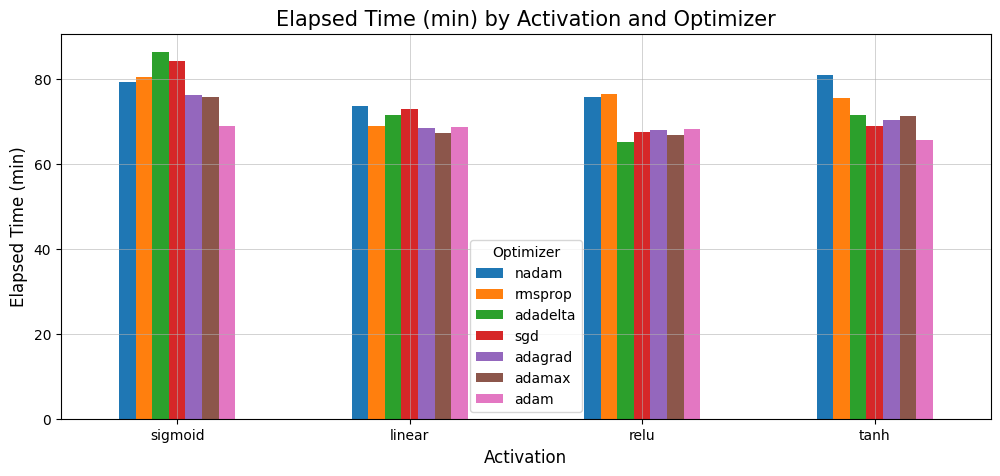

In [299]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_time = df_result.pivot_table(index='Activation', columns='Optimizer', values='Elapsed Time (min)')
# Sort the columns based on the mean elapsed time value
df_time = df_time[df_time.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_time = df_time.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean elapsed time value
df_time = df_time.sort_values(by=df_time.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_time.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Elapsed Time (min)', fontsize=12)
ax.set_title('Elapsed Time (min) by Activation and Optimizer', fontsize=15)
# formatter = ticker.PercentFormatter(xmax=1, decimals=0)
# ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

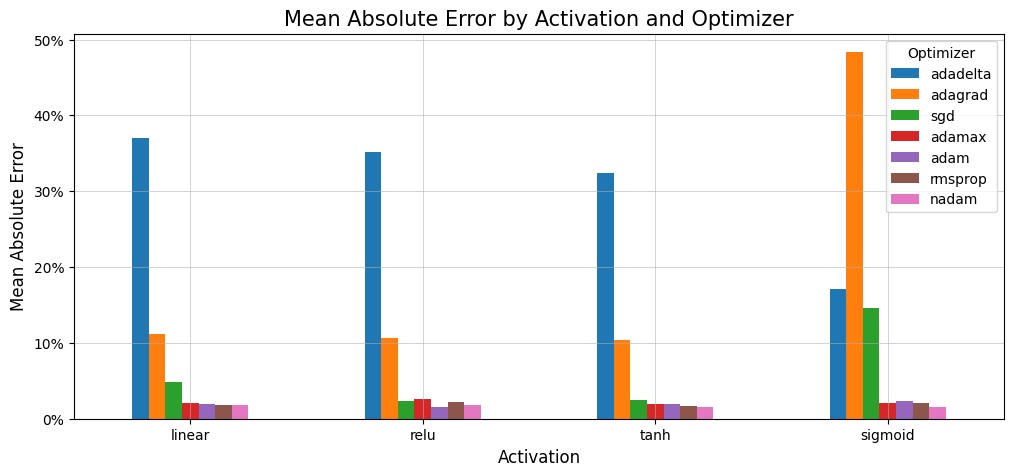

In [300]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mae = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAE (%)')
# Sort the columns based on the mean MAE value
df_mae = df_mae[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mae = df_mae.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAE value
df_mae = df_mae.sort_values(by=df_mae.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mae.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Error', fontsize=12)
ax.set_title('Mean Absolute Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

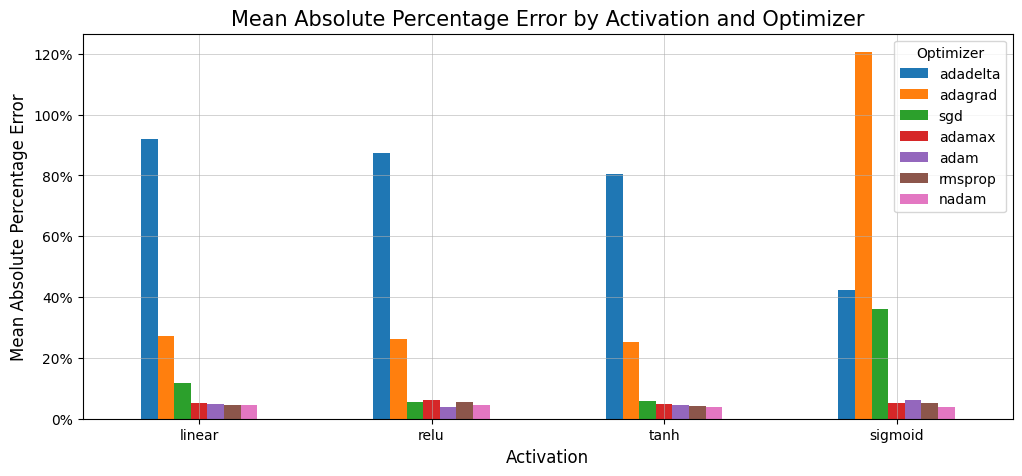

In [301]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mape = df_result.pivot_table(index='Activation', columns='Optimizer', values='MAPE (%)')
# Sort the columns based on the mean MAPE value
df_mape = df_mape[df_mae.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mape = df_mape.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MAPE value
df_mape = df_mape.sort_values(by=df_mape.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_mape.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Absolute Percentage Error', fontsize=12)
ax.set_title('Mean Absolute Percentage Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

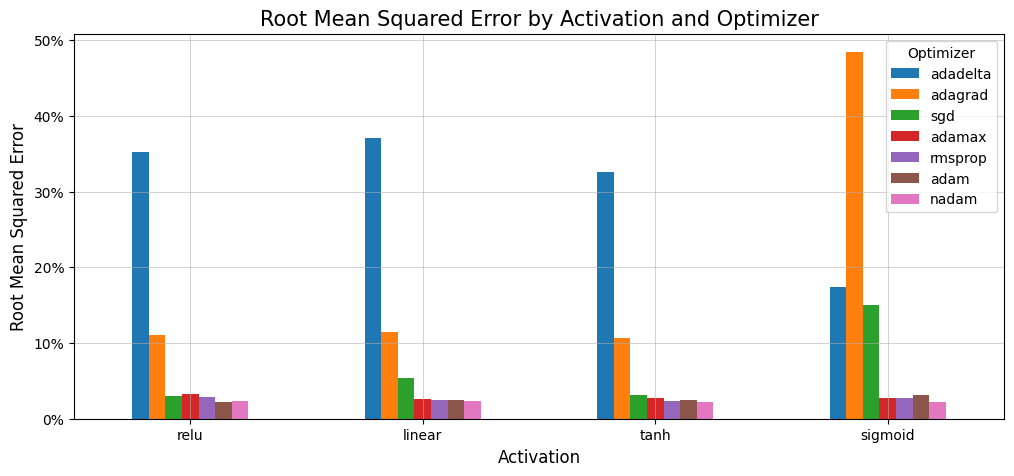

In [302]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_rmse = df_result.pivot_table(index='Activation', columns='Optimizer', values='RMSE (%)')
# Sort the columns based on the mean RMSE value
df_rmse = df_rmse[df_rmse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_rmse = df_rmse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean RMSE value
df_rmse = df_rmse.sort_values(by=df_rmse.columns[-1], ascending=False)

# Create the bar chart
fig, ax = plt.subplots(figsize=(12,5))
df_rmse.plot(kind='bar', ax=ax)
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Root Mean Squared Error', fontsize=12)
ax.set_title('Root Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

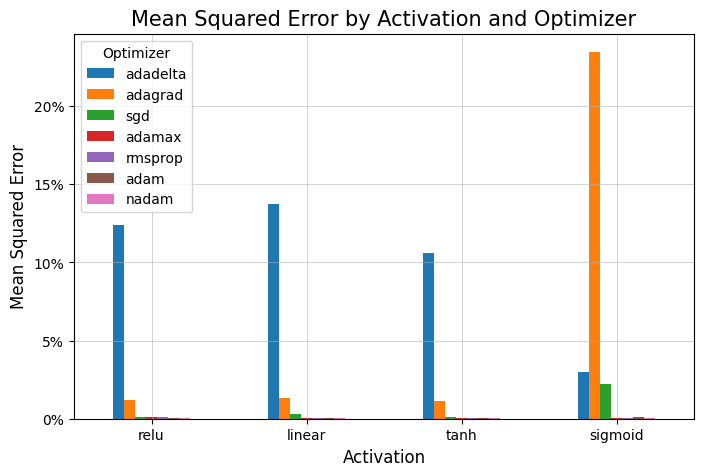

In [303]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_mse = df_result.pivot_table(index='Activation', columns='Optimizer', values='MSE (%)')
# Sort the columns based on the mean MSE value
df_mse = df_mse[df_mse.mean().sort_values(ascending=False).index]
# Sort the rows based on the activation function
df_mse = df_mse.sort_index(ascending=False)
# Sort the values in the x-axis in descending order based on the highest mean MSE value
df_mse = df_mse.sort_values(by=df_mse.columns[-1], ascending=False)

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_mse.plot(kind='bar', ax=ax) # modified line
ax.set_xlabel('Activation', fontsize=12)
ax.set_ylabel('Mean Squared Error', fontsize=12) # modified line
ax.set_title('Mean Squared Error by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.yaxis.set_major_formatter(formatter) # modified line
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0) # modified line
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()

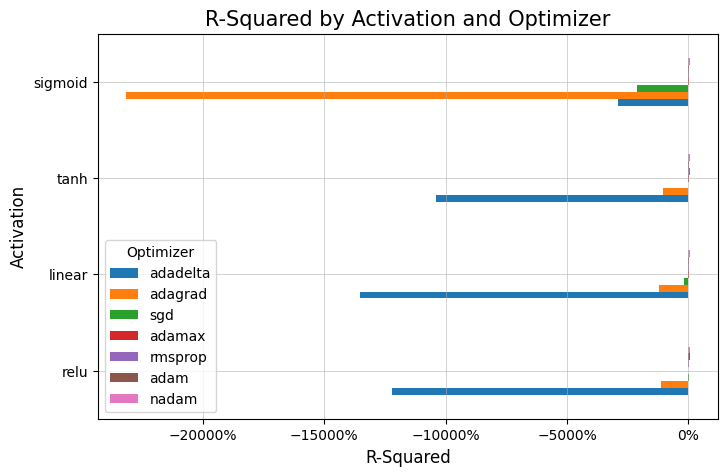

In [304]:
# Pivot the DataFrame to create a table with optimizer as columns and activation as rows
df_r2 = df_result.pivot_table(index='Activation', columns='Optimizer', values='R-Squared (%)')
# Sort the columns based on the mean R2 value
df_r2 = df_r2[df_r2.mean().sort_values(ascending=True).index]
# Sort the rows based on the activation function
df_r2 = df_r2.sort_index(ascending=True)
# Sort the values in the x-axis in descending order based on the highest mean R2 value
df_r2 = df_r2.sort_values(by=df_rmse.columns[-1], ascending=True)

# Create the bar chart
fig, ax = plt.subplots(figsize=(8,5))
df_r2.plot(kind='barh', ax=ax)
ax.set_xlabel('R-Squared', fontsize=12)
ax.set_ylabel('Activation', fontsize=12)
ax.set_title('R-Squared by Activation and Optimizer', fontsize=15)
formatter = ticker.PercentFormatter(xmax=1, decimals=0)
ax.xaxis.set_major_formatter(formatter)
ax.grid(True, linewidth='0.4')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
# ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1.02))
plt.show()